In [2]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import warnings 
warnings.filterwarnings("ignore")

# 初始化

In [3]:
from DFTStructureGenerator import DFThandle, xtb_process, mol_manipulation, logfile_process, Tool, gendes
import glob, os, shutil, itertools, copy
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Geometry import Point3D
import numpy as np
from tqdm import tqdm
import pandas as pd
from hyperopt import hp
from morfeus import BuriedVolume
from sklearn.base import clone
import seaborn as sns

In [4]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.gaussian_process import GaussianProcessRegressor

from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import KFold, cross_val_score
import pickle
np.random.seed(0)

In [5]:
from matplotlib import pyplot as plt
def calc_distribution2(y, eachsize=0.01, title=None, xlab=None, ylab="Count", y_max=None, y_min=None, color="green"):
    if y_max == None:    y_max = np.max(y)
    if y_min == None:    y_min = np.min(y)
    X = np.arange(y_min, y_max + eachsize, eachsize)
    des = [0 for each in X]
    z = (y - y_min)/eachsize
    for each in z:
        try:
            des[int(each)] += 1
        except:
            continue
    des = np.array(des)
    # des = des / len(y)
    
    fig = plt.figure(figsize=(4,3))
    ax = fig.add_subplot(111)
    ax.patch.set_alpha(0.0)
    plt.bar(X, des, width=eachsize/2, color=color)
    plt.xlim(y_min - eachsize, y_max + eachsize)
    plt.ylim(0, np.max(des) * 1.2)
    plt.xlabel(xlab, fontsize=30)
    plt.ylabel(ylab, fontsize=30)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    if title != None:
        plt.title = title
    plt.tight_layout()
    plt.savefig("test.png", format="png", dpi=300, bbox_inches='tight')
    plt.show()
    return des

def plot_scatter_with_metrics(x, y, title=None, min_=-10, max_=60, figsize = (5,5)):
    """
    绘制散点图并显示回归性能指标
    
    参数：
    x: 一维数组类型，表示x轴数据。
    y: 一维数组类型，表示y轴数据。
    title: 字符串类型，表示图的标题。
    
    返回值：
    None
    
    """
    # 计算回归性能指标
    r2 = r2_score(x, y)
    mae = mean_absolute_error(x, y)
    mse = mean_squared_error(x, y)

    # 绘制散点图
    plt.figure(figsize=figsize, facecolor='white')
    plt.xlim(min_, max_)
    plt.ylim(min_, max_)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    # plt.xlabel("Real", fontsize=18)
    # plt.ylabel("Prediction", fontsize=18)
    if title != None:
        plt.title("%s\nR2:%.3f, MAE:%.3f, MSE:%.3f" % (title, r2, mae, mse), fontsize=24)
        plt.title("%s"%title,fontsize=24)
    z = np.linspace(min_, max_, 10000)
    plt.plot(z, z)

    # plt.scatter(x, y, marker="*", c="g")
    sns.kdeplot(x=x, y=y, cmap="Blues", shade=True, bw_adjust=1, thresh=0.01)
    # 添加回归性能指标到图像的第二行
    
    # 显示图像
    plt.savefig("test.png", format="png", dpi=300, bbox_inches='tight')
    plt.show()

In [5]:
def read_reaction_csv(file_path = "Data/Second_result copy.csv"):
    data_csv = pd.read_csv(file_path)
    # removed_ids = [id for id, each in data_csv.iterrows() if np.isnan(each['E'])]
    # data_csv = data_csv.drop(removed_ids)
    data_csv.reset_index(drop=True, inplace=True)
    smiles_csv = pd.read_csv("Data_clear_with_sites.csv")
    indexs = smiles_csv["Index"].to_list()
    data_csv["Binol_smiles"] = [smiles_csv["Smiles"][indexs.index(each["Binol"])] for id, each in data_csv.iterrows()]
    data_csv["Ligand_smiles"] = [smiles_csv["Smiles"][indexs.index(each["Ligand"])] for id, each in data_csv.iterrows()]
    return data_csv

In [26]:
binol_3_3 = [1,2,3,13,18,19,20,21,23,24,25,26,28,29,30] + np.arange(122, 131).tolist()
binol_4_4 = [62,63,66]
binol_6_6 = [31,32,35,36,] + np.arange(44, 48).tolist()
binol_7_7 = [51,52,56,57,60]
binol_other = [0,85,91,121]
all_binol_split = [binol_3_3, binol_4_4, binol_6_6, binol_7_7, binol_other]

In [ ]:
csvs = glob.glob("Data\Iteration_Data2\*.csv")
target_df = pd.concat([pd.read_csv(each) for each in csvs])
target_df.to_csv(f"TEST3.csv", index=False)
    

In [33]:
csvs = glob.glob("Data/Iteration_2/Result/BINOL_result_0*.csv")
for id_, _ in enumerate(csvs):
    target_df = pd.DataFrame()
    for csv in csvs[:id_ + 1]:
        temp_df = pd.read_csv(csv).dropna()
        target_df = pd.concat([target_df, temp_df])
    target_df.to_csv(f"Data/Iteration_2/Result/BINOL_result_sum_{id_:04}.csv", index=False)
    

In [7]:
data_csv = read_reaction_csv("Data/Iteration_2/Result/BINOL_result_sum_0014.csv")
# data_csv2 = read_reaction_csv("Data/BINOL_result_6_01.csv")
# data_csv3 = read_reaction_csv("Data/BINOL_result_6_12.csv")
# data_csv4 = read_reaction_csv("Data/BINOL_result_6_21.csv")
# data_csv5 = read_reaction_csv("Data/BINOL_result_6_29.csv")
# data_csv = read_reaction_csv("Data/BINOL_result_7_08.csv")

# 传统描述符

In [30]:
smiles_csv = pd.read_csv("Data_clear_with_sites.csv")

In [31]:
gen_2D = gendes.generate2Ddesc(smiles_csv, smiles_columns=["Smiles"])
rd_mf_map = gen_2D.calc_rdkit_mf()
rd_des_map = gen_2D.calc_rdkit_desc()
morgan_map = gen_2D.calc_morgan_mf()
modred_map = gen_2D.calc_modred_desc()

  4%|▎         | 30/835 [00:11<03:04,  4.36it/s] 

c:\Users\Jackie\anaconda3\envs\main\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\Jackie\anaconda3\envs\main\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\Jackie\anaconda3\envs\main\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 12%|█▏        | 98/835 [00:12<00:23, 31.98it/s]

c:\Users\Jackie\anaconda3\envs\main\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 12%|█▏        | 104/835 [00:12<00:28, 25.86it/s]

c:\Users\Jackie\anaconda3\envs\main\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\Jackie\anaconda3\envs\main\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 13%|█▎        | 109/835 [00:13<00:32, 22.52it/s]

c:\Users\Jackie\anaconda3\envs\main\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 14%|█▎        | 113/835 [00:13<00:32, 22.52it/s]

c:\Users\Jackie\anaconda3\envs\main\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 14%|█▍        | 117/835 [00:13<00:29, 24.67it/s]

c:\Users\Jackie\anaconda3\envs\main\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 17%|█▋        | 141/835 [00:13<00:17, 39.65it/s]

c:\Users\Jackie\anaconda3\envs\main\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\Jackie\anaconda3\envs\main\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\Jackie\anaconda3\envs\main\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\Jackie\anaconda3\envs\main\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 17%|█▋        | 143/835 [00:13<00:17, 39.65it/s]

c:\Users\Jackie\anaconda3\envs\main\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 18%|█▊        | 153/835 [00:14<00:26, 25.32it/s]

c:\Users\Jackie\anaconda3\envs\main\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 27%|██▋       | 227/835 [00:16<00:20, 29.53it/s]

c:\Users\Jackie\anaconda3\envs\main\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\Jackie\anaconda3\envs\main\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\Jackie\anaconda3\envs\main\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 30%|███       | 253/835 [00:19<01:38,  5.94it/s]

c:\Users\Jackie\anaconda3\envs\main\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\Jackie\anaconda3\envs\main\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 835/835 [00:38<00:00, 21.79it/s]


In [32]:
gen_3D = gendes.generate3Ddesc(smiles_csv, smiles_columns=["Smiles"], mol_dir='Data/Mols')
acsf_3D_map = gen_3D.calc_acsf_desc()
soap_3D_map = gen_3D.calc_soap_desc()
mbtr_3D_map = gen_3D.calc_mbtr_desc()
lmbtr_3D_map = gen_3D.calc_lmbtr_desc()

Generate ACSF: 835it [00:01, 615.07it/s]
Generate SOAP: 835it [00:00, 4104.31it/s]
Generate MBTR: 835it [00:27, 30.32it/s]
Generate LMBTR: 835it [00:03, 215.61it/s]


In [49]:
with open(r"Data/all_fp_map2.pkl", 'wb')as f:
    # pickle.dump([rd_mf_map, rd_des_map, morgan_map, modred_map, acsf_3D_map, soap_3D_map, mbtr_3D_map, lmbtr_3D_map, qm_dict, area_dict], f)
    pickle.dump([qm_dict, area_dict], f)

In [10]:
with open(r"Data/all_fp_map2.pkl", 'rb')as f:
    # rd_mf_map, rd_des_map, morgan_map, modred_map, acsf_3D_map, soap_3D_map, mbtr_3D_map, lmbtr_3D_map, qm_dict, area_dict = pickle.load(f)
    qm_dict, area_dict = pickle.load(f)

In [67]:
len(all_des[-1])

NameError: name 'all_des' is not defined

# 整合描述符

In [8]:
def descriptor_to_array(df, descriptor_map, dicts=[]):
    desc_array = []
    for line_id, line in df.iterrows():
        L_Smiles = line['Ligand_smiles']
        Bip_Smiles = line['Binol_smiles']
        L_id = line['Ligand']
        B_id = line['Binol']
        L_list, Bip_list, L_dict, B_dict = [], [], [], []
        all_array = np.array([])
        if descriptor_map != None:
            L_list = np.array(descriptor_map[L_Smiles])
            Bip_list = np.array(descriptor_map[Bip_Smiles])
        if len(dicts) != 0:
            for each_dict in dicts:
                L_dict = each_dict[L_id]
                B_dict = each_dict[B_id]
                all_array = np.concatenate((all_array, L_dict, B_dict), axis=0)
        all_array = np.concatenate((all_array, L_list, Bip_list), axis=0)
        desc_array.append(all_array)
    desc_array = np.array(desc_array)
    return desc_array
def get_reverse_result(desc_arrays):
    first_num = len(desc_arrays[0]) - 64
    result = []
    new_results = list(range(48, 64)) + list(range(32, 48)) + list(range(16, 32)) + list(range(0, 16))
    new_results = list(range(first_num)) + list(np.array(new_results) + first_num)
    for desc_array in desc_arrays:
        result.append(desc_array[new_results])
    return np.array(result)

In [11]:
def select_independent_features(all_Xs, y, normal=True, ignored_array = []):
    ignored_X = np.array(all_Xs)[:, ignored_array]
    if normal:
        X = DFThandle.normalize_axis(np.delete(np.array(all_Xs), ignored_array, axis=1))[0]
    else:
        X = np.delete(np.array(all_Xs), ignored_array, axis=1)
    model = XGBRegressor(n_estimators = 300, )
    model.fit(X, y)
    FI = model.feature_importances_
    FI_sort = np.argsort(FI, )[::-1]
    new_X = X[:,FI_sort]
    corr_matrix = pd.DataFrame(new_X).corr().abs()
    upper_tri = corr_matrix.where(~np.tril(np.ones(corr_matrix.shape)).astype(bool))
    removed_idx = set()
    for i in range(upper_tri.shape[0]):
        if i in removed_idx:
            continue
        for j in range(i):
            if upper_tri[i][j] > 0.95:
                removed_idx.add(i)
                # print(i, j, upper_tri[i][j])
                break
    removed_des_id = [each for id, each in enumerate(FI_sort) if id in removed_idx]
    print(len(X[0]), len(X[0]) - len(removed_des_id))
    if normal:
        final_X = np.hstack((ignored_X, DFThandle.normalize_axis(np.delete(np.array(all_Xs), removed_des_id, axis=1))[0]))
    else:
        final_X = np.hstack((ignored_X, np.delete(np.array(all_Xs), removed_des_id, axis=1)))
    return final_X, removed_des_id

In [95]:
# all_des = []
# # [qm_dict, area_dict, aeif_dict, spms_dict]
y = data_csv['R'].to_numpy() - data_csv["S"].to_numpy()
# for des_id, des_map in enumerate([rd_mf_map, rd_des_map, morgan_map, modred_map, acsf_3D_map, soap_3D_map, mbtr_3D_map, lmbtr_3D_map, None]):#, smiles_vae_map, smiles_trfm_map, graph_gae_map]:
#     # desc_array = descriptor_to_array(data_csv, des_map)
#     desc_array = descriptor_to_array(data_csv, des_map, [qm_dict, area_dict])
#     all_des.append(desc_array)
# # all_des = np.array(all_des)
# print(all_des[-1].shape)
all_des = [descriptor_to_array(data_csv, None, [qm_dict, area_dict])]

In [13]:
all_models = [GradientBoostingRegressor, AdaBoostRegressor, XGBRegressor, RandomForestRegressor, ExtraTreesRegressor]
# all_models = [GradientBoostingClassifier, AdaBoostClassifier, XGBClassifier, RandomForestClassifier, ExtraTreesClassifier]
model_names = ["GB", "ADB", "XGB", "RF", "ET"]
des_names = ["rd_des", "morgan", "rd_mf", "modred", "acsf", "soap", "mbtr", "lmbtr", "qt"] # "vae", "trfm", "gae", "QM"]
n_est_list = [100, 200,300]
max_depth_list = [2,3,4,5,6]
mss_list = [2,3,4,5,6]
msl_list = [1,2,3,4]
n_jobs = [1]
GB_space = {"n_estimators": hp.choice("n_estimators", n_est_list), 
         "min_samples_split": hp.choice("min_samples_split", mss_list), 
         "min_samples_leaf": hp.choice("min_samples_leaf", msl_list)}
GB_hyper = [n_est_list, mss_list, msl_list]
CB_space = {"iterations": hp.choice("iterations", [1000, 5000, 10000]), 
         "learning_rate": hp.choice("learning_rate", [0.01, 0.05, 0.1]), 
         "depth": hp.choice("depth", [5,6,7])}
CB_hyper = [[1000, 5000, 10000], [0.01, 0.05, 0.1], [5,6,7]]
ADB_space = {"n_estimators": hp.choice("n_estimators", n_est_list),}
ADB_hyper = [n_est_list]
XGB_space = {"n_estimators": hp.choice("n_estimators", n_est_list), 
            "max_depth": hp.choice("max_depth", max_depth_list),
            "n_jobs": hp.choice("n_jobs", n_jobs)}
XGB_hyper = [n_est_list, max_depth_list, n_jobs]
RF_ET_space = {"n_estimators": hp.choice("n_estimators", n_est_list), 
         "min_samples_split": hp.choice("min_samples_split", mss_list), 
         "min_samples_leaf": hp.choice("min_samples_leaf", msl_list)}
RF_ET_hyper = [n_est_list, mss_list, msl_list]
GP_space = {
   "alpha": hp.choice("alpha", [1e-5, 1e-4, 1e-3, 1e-2,]),
   "kernel": hp.choice("kernel", ["RBF", "Matern", "RationalQuadratic"]),
}
GP_hyper = [[1e-5, 1e-4, 1e-3, 1e-2], ["RBF", "Matern", "RationalQuadratic"]]
spaces = [GB_space, ADB_space, XGB_space, RF_ET_space, RF_ET_space]
hypers = [GB_hyper, ADB_hyper, XGB_hyper, RF_ET_hyper, RF_ET_hyper]

In [ ]:
from rdkit.Chem import Descriptors
list(Descriptors._descList)

In [11]:
def hyperopt_RF_result(_model, space, hyper, n_fold, X, Y, train_ids):
    def hyperopt_RF(param):
        cv = KFold(n_splits=5, shuffle=True, random_state=0)
        model = _model(**param)
        acc = cross_val_score(model, X, Y, n_jobs=n_fold, cv=cv).mean()
        return {"loss":-acc, "status": STATUS_OK}
    trials = Trials()
    best = fmin(
        fn = hyperopt_RF,
        space=space,
        algo=tpe.suggest,
        max_evals=10,
        trials=trials)
    result_dict = {}
    for idx, name in enumerate(space.keys()):
        result_dict[name] = hyper[idx][best[name]]
    return result_dict

# Double K-Fold
def model_doublekfold_param_select_test_result(Xs, Y, models, spaces, hypers, n_fold, model_names, des_names):
    all_R2s, all_ps = [], []
    all_results = [] 
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    for X_id, X in enumerate(Xs):
        results = []
        all_r2 = []
        for model_id, model in enumerate(models):
            # try:
            result = np.zeros(len(X))
            temp_r2s = []
            for train_ids, test_ids in kf.split(X):
                best_param = hyperopt_RF_result(model, spaces[model_id], hypers[model_id], n_fold, X[train_ids], Y[train_ids], train_ids)
                new_model = model(**best_param)
                new_model.fit(X[train_ids], Y[train_ids])
                Y_pred = new_model.predict(X[test_ids])
                r2_s = r2_score(Y[test_ids], Y_pred)
                # r2_s = roc_auc_score(Y[test_ids], Y_pred)
                # r2_s = accuracy_score(Y[test_ids], Y_pred)
                # print("model: {}, des: {}, r2_score: {}, best_param: {}".format(model_names[model_id], des_names[X_id], r2_s, best_param))
                temp_r2s.append(r2_s)
                for test_id, pred_y in zip(test_ids, Y_pred):
                    result[test_id] = pred_y
            r2_s = np.mean(temp_r2s)
            all_r2.append(r2_s)
            results.append(result)
            # except:
                # all_r2.append(0)
            print("model: {}, des: {}, r2_score: {}".format(model_names[model_id], des_names[X_id], r2_s))
        all_R2s.append(all_r2)
        all_results.append(results)
    return all_R2s, all_results
all_r2s, result = model_doublekfold_param_select_test_result(
    Xs = all_des, 
    # Y = data_csv['E'].to_numpy(), 
    Y = y,
    # Y = np.array([1 if np.abs(each - 50) > 10 else 0 for each in data_csv['E']]),
    # Y = np.array([1 if np.abs(each) > 20 else 0 for each in y]),
    models = np.array(all_models),
    hypers = np.array(hypers),
    spaces = np.array(spaces),
    n_fold = 5,
    model_names = np.array(model_names),
    des_names = np.array(des_names),
)
print(all_r2s)

NameError: name 'all_des' is not defined

In [13]:
def half_ood_folds_(data_csvs, folds=5,seed=0):
    np.random.seed(seed)
    all_strs = set()
    banned_binol = []
    for row_id, row in data_csvs[0].iterrows():
        all_strs.add(f"{row['Binol']}_{row['Ligand']}")
    for row_id, row in data_csvs[-1].iterrows():
        if f"{row['Binol']}_{row['Ligand']}" not in all_strs:
            banned_binol.append(row['Binol'])
    allowed_binol = [each for each in np.unique(data_csvs[0]['Binol']) if each not in banned_binol]
    np.random.shuffle(allowed_binol)
    remain_binol = allowed_binol
    final_result = []
    for _ in range(folds):
        test_binol = remain_binol[:int(len(allowed_binol)/ folds)]
        remain_binol = remain_binol[int(len(allowed_binol)/ folds):]
        temp_result = []
        for data_csv in data_csvs:
            data1_test_ids = [row_id for row_id, row in data_csv.iterrows() if row['Binol'] in test_binol]
            data1_train_ids = [row_id for row_id, row in data_csv.iterrows() if row['Binol'] not in test_binol]
            temp_result.append([data1_train_ids, data1_test_ids])
        final_result.append(temp_result)
    return final_result

def new_in_final(data_csvs):
    all_strs = set()
    test_rows = []
    for row_id, row in data_csvs[-2].iterrows():
        all_strs.add(f"{row['Binol']}_{row['Ligand']}")
    for row_id, row in data_csvs[-1].iterrows():
        if f"{row['Binol']}_{row['Ligand']}" not in all_strs:
            test_rows.append(row)
    test_rows = pd.DataFrame(test_rows)
    print(len(test_rows))
    final_result = []
    for data_csv in data_csvs[:-1]:
        new_data_csv = data_csv._append(test_rows)
        print(len(data_csv), len(new_data_csv))
        new_train_ids = np.arange(len(data_csv))
        new_test_ids = np.arange(len(data_csv), len(new_data_csv))
        final_result.append([new_data_csv, new_train_ids, new_test_ids])
    return final_result

In [22]:
len(a), len(b), len(c), len(d)

(469, 99, 519, 99)

In [12]:
# data_csv = read_reaction_csv("Data/Result/BINOL_result_sum_0015.csv")
final_all_r2s, final_mae, final_pred = [], [], []
all_r2_split = [[] for _ in range(len(all_binol_split))]
for data_csv in [read_reaction_csv(each) for each in glob.glob("Data/Iteration_2/Result/BINOL_result_sum_*.csv")]:
    y = data_csv['R'].to_numpy() - data_csv["S"].to_numpy()
    all_X = descriptor_to_array(data_csv, None, [qm_dict, area_dict])
    target = y
    all_r2s = []
    all_mae = []
    all_pred = np.array([0 for _ in range(len(all_X))])
    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    kf = list(kf.split(all_X))
    for train_ids, test_ids in kf:
        model = CatBoostRegressor(iterations=10000, learning_rate=0.01, depth=6, verbose=0, random_state = 0)
        train_X, train_Y = all_X[train_ids], target[train_ids]
        temp_train_X =  get_reverse_result(train_X)
        temp_train_Y = train_Y * -1
        train_X_ = np.concatenate([train_X, temp_train_X])
        train_Y_ = np.append(train_Y, temp_train_Y)
        model.fit(train_X_, train_Y_)
        y_pred = model.predict(all_X[test_ids])
        r2s = r2_score(target[test_ids], y_pred)
        all_r2s.append(r2s)
        all_mae.append(mean_absolute_error(target[test_ids], y_pred))
        all_pred[test_ids] = y_pred
    for binol_split_id, binol_split in enumerate(all_binol_split):
        row_in_split = [id_ for id_, each in data_csv.iterrows() if each['Binol'] in binol_split]
        all_r2_split[binol_split_id].append(r2_score(target[row_in_split], all_pred[row_in_split]))
    print(np.mean(all_r2s))
    print(np.mean(all_mae))
    final_all_r2s.append(np.mean(all_r2s))
    final_mae.append(np.mean(all_mae))
    final_pred.append(all_pred)

-0.19504510404811196
4.794535829851344
0.5726228142794458
8.282385446685177
0.6172952513648577
7.325983914199954
0.6878424223730026
9.224967728046163
0.7734030709835695
8.865969082698967
0.8132836055385511
9.593313787577689
0.7966347811605484
9.76112585291796
0.8030095749527145
10.794384741305844
0.7968821743483494
11.739156609609555
0.8231698937385616
11.389404264384927
0.8438515576056311
11.186971343055735
0.8515609048500838
11.28032549447599
0.8600808455860754
10.78227497961301
0.8503816935964423
11.218651509521706
0.852516302811623
11.23106121401255


In [37]:
pd.DataFrame(np.array(all_r2_split)).to_csv('test.csv')

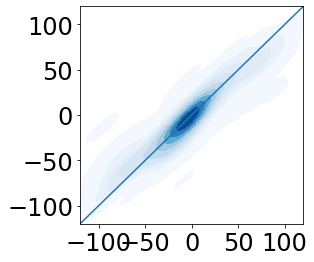

In [21]:
plot_scatter_with_metrics(y, all_pred, min_=-120, max_=120, figsize=(4,4))


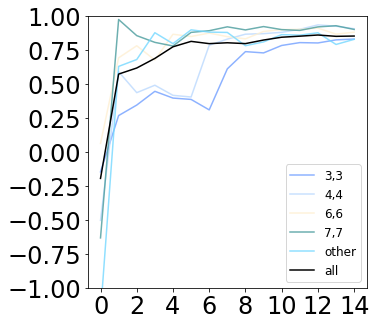

In [20]:
plt.figure(figsize=(5, 5))
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

for color, r2_split, name in zip(['#719fff', '#bbd9fe', '#feefd2', '#489b9c', '#74d8ff', '#e6e6e6'], all_r2_split, ["3,3", '4,4', '6,6', '7,7', 'other']):
    plt.plot(np.arange(len(r2_split)), r2_split, c=color, label=name, alpha=0.8)
plt.plot(np.arange(len(final_all_r2s)), final_all_r2s, c='black', label="all", )
plt.ylim(-1,1)

plt.legend(fontsize=12)
plt.savefig('test.png', dpi=300, bbox_inches='tight')

In [ ]:
#OOD results
0.8093458665085584 11.034576660156468 269.97048474464054
0.780459739777701 10.19136848783949 221.99590017379904
0.8027539961966308 11.459615231906557 254.33527797806678
0.9014696122687181 9.081233970808375 161.910532599568
0.7110523290306049 13.42251965551659 360.40188439279905
0.8010163087564427
11.037862801245495

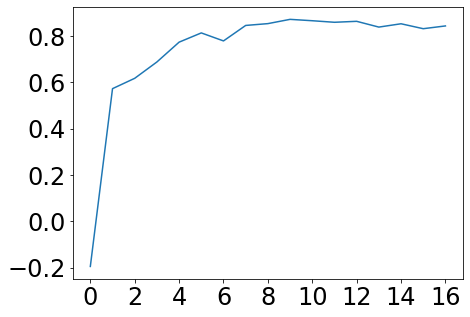

In [85]:
plt.figure(figsize=(7,5))
# plt.xlim(0,6)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.plot(np.arange(17), [-0.19504510404811196, 0.5726228142794458, 0.6172952513648577, 0.6878424223730026, 0.7734030709835695, 0.8132836055385511, 0.7787317590796764, 0.8455662396840585, 0.8533833065865494, 0.8718382284775077,0.8659059972370915,0.8592084583484179, 0.8633512765165984, 0.838445684306121, 0.8527702387154805, 0.8314979188733368, 0.8434133637316575])


In [ ]:
data_csvs = [data_csv, data_csv2, data_csv3, data_csv4, data_csv5, data_csv6]
data_csvs = [data_csv, data_csv2, data_csv3, data_csv4]
fold_results = half_ood_folds_(data_csvs, folds=5,seed=0)
r2s = [[] for _ in data_csvs]
real_pred = [[[], []] for _ in data_csvs]
for fold_id, fold_result in enumerate(fold_results):
    for r2_id, (train_ids, test_ids) in enumerate(fold_result):
        all_X_1 = descriptor_to_array(data_csvs[r2_id], mbtr_3D_map, [qm_dict, area_dict])
        target_1 = data_csvs[r2_id]['R'].to_numpy() - data_csvs[r2_id]["S"].to_numpy()
        model = CatBoostRegressor(iterations=10000, learning_rate=0.01, depth=6, verbose=0, random_state = 0)
        model.fit(all_X_1[train_ids], target_1[train_ids])
        y_pred_1 = model.predict(all_X_1[test_ids])
        print(r2_score(target_1[test_ids], y_pred_1), mean_absolute_error(target_1[test_ids], y_pred_1), mean_squared_error(target_1[test_ids], y_pred_1))
        r2s[r2_id].append(r2_score(target_1[test_ids], y_pred_1))
        real_pred[r2_id][0] += target_1[test_ids].tolist()
        real_pred[r2_id][1] += y_pred_1.tolist()
[np.mean(each) for each in r2s]

In [24]:
# data_csvs = [data_csv, data_csv2, data_csv3, data_csv4, data_csv5, data_csv6]
data_csvs = [data_csv, data_csv2, data_csv3, data_csv4]
new_final_results = new_in_final(data_csvs)
r2s = []
real_pred = []
for each_data_csv, train_ids, test_ids in new_final_results:
    all_X_1 = descriptor_to_array(each_data_csv, mbtr_3D_map, [qm_dict, area_dict])
    target_1 = each_data_csv['R'].to_numpy() - each_data_csv["S"].to_numpy()
    model = CatBoostRegressor(iterations=10000, learning_rate=0.01, depth=6, verbose=0, random_state = 0)
    # train_X, train_Y = all_X_1[train_ids], target_1[train_ids]
    # temp_train_X =  get_reverse_result(train_X)
    # temp_train_Y = train_Y * -1
    # train_X_ = np.hstack([train_X, temp_train_X])
    # train_Y_ = np.append([train_Y, temp_train_Y])
    model.fit(all_X_1[train_ids], target_1[train_ids])
    y_pred_1 = model.predict(all_X_1[test_ids])
    print(r2_score(target_1[test_ids], y_pred_1), mean_absolute_error(target_1[test_ids], y_pred_1), mean_squared_error(target_1[test_ids], y_pred_1))
    r2s.append(r2_score(target_1[test_ids], y_pred_1))
    real_pred.append([target_1[test_ids], y_pred_1])
[np.mean(each) for each in r2s]

0it [00:00, ?it/s]

618it [00:00, 11035.62it/s]

50
568 618
616 666
666 716



666it [00:00, 11482.79it/s]

0.302989478744213 15.20785582926441 510.2440428474223



716it [00:00, 10505.64it/s]

0.6460565362190461 12.432374199757762 259.1030384643777


0.6102140938725433 12.741346536339806 285.34136935134256


[0.302989478744213, 0.6460565362190461, 0.6102140938725433]

In [25]:
all_X_2.shape

(618, 167)

In [ ]:
final_all_r2s = [0.802, 0.814]
final_mae = [8.97, 8.95]
ood_r2 = [, 0.673]
ood_mae = [10.72]

In [ ]:
from tqdm import tqdm
def feature_selection(X, y, already_selected):
    remain_list = already_selected
    all_list = list(range(len(X[0])))
    # removed_lists = Bayesian_Optimization.index_of_highly_correlated_features(X, threshold=0.98)

    for idx in range(150):
        all_r2 = []
        for id, each in enumerate(all_list):
            print(id, len(all_list), end='\r')
            if each in remain_list:
                all_r2.append(-10)
                continue
            temp_remain_list = remain_list + [each]
            X_new = X[:, temp_remain_list]
            cv = KFold(n_splits=5, shuffle=True)
            model = CatBoostRegressor(iterations=300, learning_rate=0.1, depth=6, verbose=0, random_state = 0)
            # model = GradientBoostingRegressor(n_estimators=300)
            acc = cross_val_score(model, X_new, y, cv=cv, n_jobs=-1).mean()
            all_r2.append(acc.mean())
        max_id = np.argmax(all_r2)
        remain_list.append(max_id)
        print(np.max(all_r2), remain_list)
    return all_r2, remain_list
all_X = all_des[6][np.argsort(error_pred)[:-id]]
all_r2, y_in_removed_lists = feature_selection(all_X, y[np.argsort(error_pred)[:-id]], already_selected = [])

In [ ]:
all_r2s = [[0.6451881375436939, 0.5120043159008134, 0.6415848419152745, 0.6300015133303501, 0.6147291123394446], [0.6456476921152595, 0.5060841338084703, 0.6172119357908854, 0.6339770130892683, 0.6331507284393308], [0.6601769668751787, 0.478694780527767, 0.6519559366048598, 0.6493369728856306, 0.6455492365164073], [0.6406315222194107, 0.47122580070279624, 0.6009923865127623, 0.6222345771485212, 0.6220428630540314], [0.6410413523044161, 0.5014006238100689, 0.606815130721446, 0.6364240162440877, 0.6108095748710085], [0.6465252559144525, 0.48265116397513913, 0.6129367891018205, 0.6055426168973088, 0.6064107772434075], [0.6686530584956287, 0.5016814780713255, 0.6539200898844888, 0.6359016910640648, 0.6452680330975135], [0.6137321902968476, 0.4824112069020391, 0.5962976280433014, 0.6127970507155768, 0.6103137369531312], [0.6428330706451936, 0.4742388425227576, 0.6231876787895458, 0.629408022307914, 0.6287948717183867]]

50 0.302989478744213 15.20785582926441 510.2440428474223
50 0.6460565362190461 12.432374199757762 259.1030384643777
50 0.6102140938725433 12.741346536339806 285.34136935134256


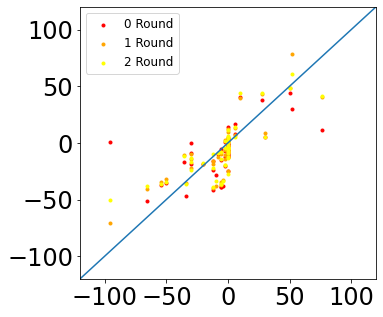

In [25]:
plt.figure(figsize=(5.3,5))
min_, max_ = -120, 120
plt.xlim(min_, max_)
plt.ylim(min_, max_)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
z = np.linspace(min_, max_, 10000)
plt.plot(z, z)
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'gray', 'black']
labels = [f'{each} Round' for each in range(len(real_pred))]
for id_, [a,b] in enumerate(real_pred):
    print(len(a), r2_score(a, b), mean_absolute_error(a, b), mean_squared_error(a, b))
    plt.scatter(a, b, marker=".", c=colors[id_], label=labels[id_])
plt.legend(fontsize=12)
plt.savefig("test.svg", format="svg")
plt.show()

In [56]:
data_csv['Real'] = y
data_csv["Pred"] = all_pred
data_csv["Error"] = np.abs(all_pred - y)
data_csv.to_csv("Data/BINOL_result_4_28_error.csv")

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_auc_roc(y_true, y_scores):
    """
    绘制 AUROC 曲线的函数。
    
    参数:
    - y_true: 真实标签数组。
    - y_scores: 预测得分数组，即模型预测为正类的概率。
    """
    # 计算 ROC 曲线的坐标
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    # 计算 AUC 分数
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

def calculate_confusion_matrix_values(y_true, y_pred):
    """
    根据真实标签和预测标签计算 TP, FP, TN, FN。
    
    参数:
    - y_true: 真实的标签列表或数组。
    - y_pred: 预测的标签列表或数组。
    """
    TP = FP = TN = FN = 0
    for true, pred in zip(y_true, y_pred):
        if true == 1 and pred == 1:
            TP += 1
        elif true == 1 and pred == 0:
            FN += 1
        elif true == 0 and pred == 1:
            FP += 1
        elif true == 0 and pred == 0:
            TN += 1
            
    return TP/len(y_true), FP/len(y_true), TN/len(y_true), FN/len(y_true)

calculate_confusion_matrix_values(b, result[1][-1])

# 新型描述符

In [28]:
Chem.MolToSmiles(Chem.MolFromSmiles("[H][C@]12N(C[C@@H]3[C@](CCCC4)([H])N4C[C@H]2C3)CCCC1"))

'C1CCN2C[C@H]3C[C@H](CN4CCCC[C@@H]34)[C@H]2C1'

#### 统计反应位点

In [13]:
import torch
mask = torch.zeros(10, dtype=torch.bool)

In [6]:
smiles_csv = pd.read_csv("Data_new_2.csv")
smiles_csv['Sites'] = {}
for row_id, row in smiles_csv.iterrows():
    binol_smiles = row["Smiles"]
    binol_mol = Chem.MolFromSmiles(binol_smiles)
    if row["Type"] == "Binol":
        subset = binol_mol.GetSubstructMatches(Chem.MolFromSmarts("[OH]c1ccccc1-c1ccccc1[OH]"))
        subset = subset[0]
        smiles_csv['Sites'][row_id] = f"{subset[0]} {subset[-1]}"
    elif row["Type"] in ["Ligand_Box", "Ligand_Other"]:
        mol = binol_mol
        Chem.Kekulize(mol, clearAromaticFlags=True)
        sites = set()
        subset = mol.GetSubstructMatches(Chem.MolFromSmarts("N~*~*~N"))
        if len(subset) == 0:
            subset = mol.GetSubstructMatches(Chem.MolFromSmarts("N~*~*~*~N"))
        if len(subset) == 0:
            subset = mol.GetSubstructMatches(Chem.MolFromSmarts("N~*~*~*~O"))
        if len(subset) == 0:
            subset = mol.GetSubstructMatches(Chem.MolFromSmarts("N~*~*~*~P"))
        if len(subset) == 0:
            subset = mol.GetSubstructMatches(Chem.MolFromSmarts("N~*~*~*~*~N"))
        if len(subset) == 0:
            subset = mol.GetSubstructMatches(Chem.MolFromSmarts("N~*~*~*~*~*~N"))
        for subset_ in subset:
            sites.add(subset_[0])
            sites.add(subset_[-1])
        smiles_csv['Sites'][row_id] = " ".join(str(site) for site in sites)
smiles_csv.to_csv("Data_clear_with_sites_new.csv", index=False)


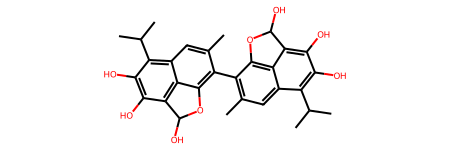

In [16]:
binol_mol

In [13]:
Chem.MolToSmiles(Chem.MolFromSmiles("O=C(C1=NC=CN=C1O)O"))

'O=C(O)c1nccnc1O'

#### 根据反应位点搭建配体——金属结构

In [ ]:
# from copy import deepcopy
# M_L_dist = 1.96
# mol_dir = "Data/Mols"
# dft_dir = "Data/GS_OPT"
# new_mol_dir = "Data/newmols4"
# new_dft_dir = "Data/newGS4"
# if not os.path.isdir(new_mol_dir):
#     os.mkdir(new_mol_dir)
# if not os.path.isdir(new_dft_dir):
#     os.mkdir(new_dft_dir)
# smiles_csv = pd.read_csv("Data_clear_with_sites.csv")
# smiles_csv = smiles_csv.loc[(smiles_csv['Type'] == "Ligand_Box") | (smiles_csv['Type'] == "Ligand_Other")]
# for row_id, row in smiles_csv.iterrows():
#     freeze = []
#     ligand_idx = row["Index"]
#     conf_id = row["conf_id"]
#     sites = [int(each) for each in row['Sites'].split()]
#     # if ligand_idx != 1002:
#     #     continue
#     mol = Chem.MolFromMolFile(os.path.join(mol_dir, f"{ligand_idx:05}.mol"), removeHs=False)
#     log = logfile_process.Logfile(os.path.join(dft_dir, f"{ligand_idx:05}_r_{conf_id:04}.log"))
#     symbol_list, positions = log.symbol_list, log.running_positions[-1:]
#     mol = xtb_process.xtb_to_mol(mol, [symbol_list], positions, 1)
#     Chem.Kekulize(mol, clearAromaticFlags=True)

#     ff = Chem.AllChem.UFFGetMoleculeForceField(mol)
#     # rwmol.AddBond(site, new_atom_id, Chem.BondType.SINGLE)
#     for site_id, site in enumerate(sites[1:]):
#         ff.UFFAddDistanceConstraint(sites[site_id],site, False, 2.0, 2.8, 1000)
#     ff.Initialize()
#     ff.Minimize()

#     binol_atoms = mol.GetNumAtoms()
#     new_mol = mol_manipulation.smiles2mol('CC#N')
#     new_mol_atoms = new_mol.GetNumAtoms()
#     new_sites = copy.deepcopy(sites)
#     if len(sites) < 4:
#         new_mol = mol_manipulation.move_mol(new_mol, np.array([20,20,-20]))
#         mol = Chem.CombineMols(mol, new_mol)
#         new_sites.append(binol_atoms + 2)
#         if len(sites) < 3:
#             new_mol = mol_manipulation.move_mol(new_mol, np.array([20,-20,20]))
#             mol = Chem.CombineMols(mol, new_mol)
#             new_sites.append(binol_atoms + new_mol_atoms + 2)

#     rwmol = Chem.RWMol(mol)
#     new_atom_id = rwmol.AddAtom(Chem.Atom("C"))
#     for site in new_sites:
#         freeze.append([site + 1, new_atom_id + 1])
#         rwmol.AddBond(site, new_atom_id, Chem.BondType.SINGLE)
#         rwmol.GetAtomWithIdx(site).SetFormalCharge(1)
#     # rwmol.GetAtomWithIdx(new_atom_id).SetFormalCharge(len(sites) - 2)
#     mol = rwmol.GetMol()
#     Chem.SanitizeMol(mol)
#     Chem.Kekulize(mol, clearAromaticFlags=True)
#     conf = mol.GetConformer(0)
#     center_position = np.mean(conf.GetPositions()[sites], axis=0)
#     conf.SetAtomPosition(new_atom_id, center_position + np.array([10, 10, 10]))
#     Chem.AllChem.UFFOptimizeMolecule(mol)

#     old_sites = sites
#     sites = new_sites + new_sites[:1]
#     ff = Chem.AllChem.UFFGetMoleculeForceField(mol)
#     for site_id, site in enumerate(sites[1:]):
#         if site not in old_sites:
#             ff.UFFAddDistanceConstraint(site, new_atom_id, False, 1.9, 2.0, 200)
#         else:
#             ff.UFFAddDistanceConstraint(site, new_atom_id, False, 2, 3, 50)
#         ff.UFFAddAngleConstraint(sites[site_id],new_atom_id,sites[site_id - 1], False, 80, 110, 10)
#     ff.UFFAddAngleConstraint(sites[0],new_atom_id,sites[2], False, 170, 190, 100)
#     ff.UFFAddAngleConstraint(sites[1],new_atom_id,sites[3], False, 170, 190, 100)
#     ff.Initialize()
#     ff.Minimize()

#     ff = Chem.AllChem.UFFGetMoleculeForceField(mol)
#     for site_id, site in enumerate(sites[1:]):
#         if site not in old_sites:
#             ff.UFFAddDistanceConstraint(site, new_atom_id, False, 1.9, 2.0, 200)
#         else:
#             ff.UFFAddDistanceConstraint(site, new_atom_id, False, 2, 2.5, 50)
#         ff.UFFAddAngleConstraint(sites[site_id],new_atom_id,sites[site_id - 1], False, 80, 110, 100)
#     ff.UFFAddAngleConstraint(sites[0],new_atom_id,sites[2], False, 170, 190, 100)
#     ff.UFFAddAngleConstraint(sites[1],new_atom_id,sites[3], False, 170, 190, 100)
#     ff.Initialize()
#     ff.Minimize()

#     ff = Chem.AllChem.UFFGetMoleculeForceField(mol)
#     for site_id, site in enumerate(sites[1:]):
#         ff.UFFAddDistanceConstraint(site, new_atom_id, False, 1.9, 2.0, 1000)
#         ff.UFFAddAngleConstraint(sites[site_id],new_atom_id,sites[site_id - 1], False, 80, 100, 1000)
#     ff.UFFAddAngleConstraint(sites[0],new_atom_id,sites[2], False, 170, 190, 100)
#     ff.UFFAddAngleConstraint(sites[1],new_atom_id,sites[3], False, 170, 190, 100)
#     ff.Initialize()
#     ff.Minimize()

#     rwmol = Chem.RWMol(mol)
#     rwmol.GetAtomWithIdx(new_atom_id).SetFormalCharge(2)
#     rwmol.GetAtomWithIdx(new_atom_id).SetAtomicNum(29)
#     for site in new_sites:
#         rwmol.RemoveBond(site, new_atom_id)
#         rwmol.GetAtomWithIdx(site).SetFormalCharge(0)
#     mol = rwmol.GetMol()
#     Chem.SanitizeMol(mol)
    
#     Chem.MolToMolFile(mol, os.path.join(new_mol_dir, f"{ligand_idx:05}.mol"))
#     symbol_list = [atom.GetSymbol() for atom in mol.GetAtoms()]
#     positions = mol.GetConformer(0).GetPositions()
#     B_N_Cl.FormatConverter.block_to_gjf(symbol_list, positions, os.path.join(new_dft_dir, f"{ligand_idx:05}.gjf"), charge=log.charge+2, multiplicity=2, title="Title", method=OPT_METHOD, freeze=[], difreeze=[], savechk=None, readchk=None, final_line=None)
#     # break

        
        
    

In [13]:
M_L_dist = 1.96
mol_dir = "Data2/Mols"
dft_dir = "Data2/GS_OPT"
new_mol_dir = "Data2/newmols"
new_dft_dir = "Data2/newGS"
if not os.path.isdir(new_mol_dir):
    os.mkdir(new_mol_dir)
if not os.path.isdir(new_dft_dir):
    os.mkdir(new_dft_dir)
smiles_csv = pd.read_csv("Data_clear_with_sites_new.csv")
smiles_csv = smiles_csv.loc[(smiles_csv['Type'] == "Ligand_Box") | (smiles_csv['Type'] == "Ligand_Other")]
for row_id, row in smiles_csv.iterrows():
    freeze = []
    ligand_idx = row["Index"]
    conf_id = row["conf_id"]
    sites = [int(each) for each in row['Sites'].split()]
    # if ligand_idx != 1002:
    #     continue
    mol = Chem.MolFromMolFile(os.path.join(mol_dir, f"{ligand_idx:05}.mol"), removeHs=False)
    log = logfile_process.Logfile(os.path.join(dft_dir, f"{ligand_idx:05}_r_{conf_id:04}.log"))
    symbol_list, positions = log.symbol_list, log.running_positions[-1:]
    mol = xtb_process.xtb_to_mol(mol, [symbol_list], positions, 1)
    Chem.Kekulize(mol, clearAromaticFlags=True)

    ff = Chem.AllChem.UFFGetMoleculeForceField(mol)
    # rwmol.AddBond(site, new_atom_id, Chem.BondType.SINGLE)
    for site_id, site in enumerate(sites[1:]):
        ff.UFFAddDistanceConstraint(sites[site_id],site, False, 2.0, 2.8, 1000)
    ff.Initialize()
    ff.Minimize()

    rwmol = Chem.RWMol(mol)
    new_atom_id = rwmol.AddAtom(Chem.Atom("O"))
    for site in sites:
        freeze.append([site + 1, new_atom_id + 1])
        rwmol.AddBond(site, new_atom_id, Chem.BondType.SINGLE)
        rwmol.GetAtomWithIdx(site).SetFormalCharge(1)
    rwmol.GetAtomWithIdx(new_atom_id).SetFormalCharge(len(sites) - 2)
    mol = rwmol.GetMol()
    Chem.SanitizeMol(mol)
    Chem.Kekulize(mol, clearAromaticFlags=True)
    conf = mol.GetConformer(0)
    center_position = np.mean(conf.GetPositions()[sites], axis=0)
    conf.SetAtomPosition(new_atom_id, center_position + np.array([10, 10, 10]))
    Chem.AllChem.UFFOptimizeMolecule(mol)

    rwmol = Chem.RWMol(mol)
    rwmol.GetAtomWithIdx(new_atom_id).SetFormalCharge(2)
    rwmol.GetAtomWithIdx(new_atom_id).SetAtomicNum(29)
    for site in sites:
        rwmol.RemoveBond(site, new_atom_id)
        rwmol.GetAtomWithIdx(site).SetFormalCharge(0)
    mol = rwmol.GetMol()
    Chem.SanitizeMol(mol)

    ff = Chem.AllChem.UFFGetMoleculeForceField(mol)
    ff.UFFAddDistanceConstraint(sites[0], new_atom_id, False, 1.3, 1.9, 10)
    # rwmol.AddBond(site, new_atom_id, Chem.BondType.SINGLE)
    for site_id, site in enumerate(sites[1:]):
        ff.UFFAddDistanceConstraint(site, new_atom_id, False, 1.3, 1.9, 10)
        ff.UFFAddAngleConstraint(sites[site_id],new_atom_id,site, False, 80, 110, 10)
    ff.Initialize()
    ff.Minimize()

    ff = Chem.AllChem.UFFGetMoleculeForceField(mol)
    ff.UFFAddDistanceConstraint(sites[0], new_atom_id, False, 1.6, 1.9, 100)
    # rwmol.AddBond(site, new_atom_id, Chem.BondType.SINGLE)
    for site_id, site in enumerate(sites[1:]):
        ff.UFFAddDistanceConstraint(site, new_atom_id, False, 1.6, 1.9, 100)
        ff.UFFAddAngleConstraint(sites[site_id],new_atom_id,site, False, 80, 110, 100)
    ff.Initialize()
    ff.Minimize()

    ff = Chem.AllChem.UFFGetMoleculeForceField(mol)
    ff.UFFAddDistanceConstraint(sites[0], new_atom_id, False, 1.95, 1.96, 1000)
    # rwmol.AddBond(site, new_atom_id, Chem.BondType.SINGLE)
    for site_id, site in enumerate(sites[1:]):
        ff.UFFAddDistanceConstraint(site, new_atom_id, False, 1.95, 1.96, 1000)
        ff.UFFAddAngleConstraint(sites[site_id],new_atom_id,site, False, 80, 100, 1000)
    ff.Initialize()
    ff.Minimize()
    Chem.MolToMolFile(mol, os.path.join(new_mol_dir, f"{ligand_idx:05}.mol"))
    symbol_list = [atom.GetSymbol() for atom in mol.GetAtoms()]
    positions = mol.GetConformer(0).GetPositions()
    DFThandle.FormatConverter.block_to_gjf(symbol_list, positions, os.path.join(new_dft_dir, f"{ligand_idx:05}.gjf"), charge=log.charge+2, multiplicity=2, title="Title", method=OPT_METHOD, freeze=[], difreeze=[], savechk=None, readchk=None, final_line=None)
    # break

        
        
    

#### 搭建Binol-金属结构

In [ ]:
# # for test CCN
# M_L_dist = 1.96
# mol_dir = "Data/Mols"
# dft_dir = "Data/GS_OPT"
# new_mol_dir = "Data/newmols3"
# new_dft_dir = "Data/newGS3"
# if not os.path.isdir(new_mol_dir):
#     os.mkdir(new_mol_dir)
# if not os.path.isdir(new_dft_dir):
#     os.mkdir(new_dft_dir)
# smiles_csv = pd.read_csv("Data_clear_with_sites.csv")
# smiles_csv = smiles_csv.loc[(smiles_csv['Type'] == "Binol")]
# for row_id, row in smiles_csv.iterrows():
#     ligand_idx = row["Index"]
#     conf_id = row["conf_id"]
#     sites = [int(each) for each in row['Sites'].split()]
#     mol = Chem.MolFromMolFile(os.path.join(mol_dir, f"{ligand_idx:05}.mol"), removeHs=False)
#     log = logfile_process.Logfile(os.path.join(dft_dir, f"{ligand_idx:05}_r_{conf_id:04}.log"))
#     symbol_list, positions = log.symbol_list, log.running_positions[-1:]
#     mol = xtb_process.xtb_to_mol(mol, [symbol_list], positions, 1)
#     Chem.Kekulize(mol, clearAromaticFlags=True)

#     binol_atoms = mol.GetNumAtoms()
#     new_mol = mol_manipulation.smiles2mol('CC#N')
#     new_mol_atoms = new_mol.GetNumAtoms()
#     new_mol = mol_manipulation.move_mol(new_mol, np.array([10,10,-10]))
#     mol = Chem.CombineMols(mol, new_mol)
#     new_mol = mol_manipulation.move_mol(new_mol, np.array([10,-10,10]))
#     mol = Chem.CombineMols(mol, new_mol)

#     rwmol = Chem.RWMol(mol)
#     for site in sites:
#         neighbor_id = [neighbor.GetIdx() for neighbor in rwmol.GetAtomWithIdx(site).GetNeighbors() if neighbor.GetSymbol() == "H"][0]
#         rwmol.RemoveAtom(neighbor_id)
#     new_atom_id = rwmol.AddAtom(Chem.Atom("C"))
#     for site in sites:
#         rwmol.AddBond(site, new_atom_id, Chem.BondType.SINGLE)
#         rwmol.GetAtomWithIdx(site).SetFormalCharge(0)
#     rwmol.AddBond(new_atom_id, binol_atoms, Chem.BondType.SINGLE)
#     rwmol.AddBond(new_atom_id, binol_atoms + new_mol_atoms, Chem.BondType.SINGLE)
#     rwmol.GetAtomWithIdx(new_atom_id).SetFormalCharge(len(sites) + 2 - 4)
#     rwmol.GetAtomWithIdx(binol_atoms).SetFormalCharge(1)
#     rwmol.GetAtomWithIdx(binol_atoms + new_mol_atoms).SetFormalCharge(1)
#     mol = rwmol.GetMol()
#     Chem.SanitizeMol(mol)
#     Chem.Kekulize(mol, clearAromaticFlags=True)
#     conf = mol.GetConformer(0)
#     center_position = np.mean(conf.GetPositions()[sites], axis=0)
#     conf.SetAtomPosition(new_atom_id, center_position + np.array([10, 10, 10]))
#     Chem.AllChem.UFFOptimizeMolecule(mol)

#     sites = sites + [binol_atoms, binol_atoms + new_mol_atoms, sites[0]]
#     ff = Chem.AllChem.UFFGetMoleculeForceField(mol)
#     ff.UFFAddDistanceConstraint(sites[0], new_atom_id, False, 1.9, 2.0, 1000)
#     # rwmol.AddBond(site, new_atom_id, Chem.BondType.SINGLE)
#     for site_id, site in enumerate(sites[1:]):
#         ff.UFFAddDistanceConstraint(site, new_atom_id, False, 1.9, 2.0, 1000)
#         ff.UFFAddAngleConstraint(sites[site_id - 1],new_atom_id,site, False, 80, 110, 200)
#     ff.UFFAddAngleConstraint(sites[0],new_atom_id,sites[2], False, 170, 190, 200)
#     ff.UFFAddAngleConstraint(sites[1],new_atom_id,sites[3], False, 170, 190, 200)
#     ff.Initialize()
#     ff.Minimize()
    


#     ff = Chem.AllChem.UFFGetMoleculeForceField(mol)
#     ff.UFFAddDistanceConstraint(sites[0], new_atom_id, False, 1.9, 2.0, 5000)
#     # rwmol.AddBond(site, new_atom_id, Chem.BondType.SINGLE)
#     for site_id, site in enumerate(sites[1:]):
#         ff.UFFAddDistanceConstraint(site, new_atom_id, False, 1.9, 2.0, 5000)
#         ff.UFFAddAngleConstraint(sites[site_id],new_atom_id,site, False, 80, 110, 100)
#     ff.UFFAddAngleConstraint(sites[0],new_atom_id,sites[2], False, 170, 190, 100)
#     ff.UFFAddAngleConstraint(sites[1],new_atom_id,sites[3], False, 170, 190, 100)
#     ff.Initialize()
#     ff.Minimize()



#     ff = Chem.AllChem.UFFGetMoleculeForceField(mol)
#     # ff.UFFAddDistanceConstraint(sites[0], new_atom_id, False, 1.95, 1.96, 10000)
#     # rwmol.AddBond(site, new_atom_id, Chem.BondType.SINGLE)
#     for site_id, site in enumerate(sites[1:]):
#         ff.UFFAddDistanceConstraint(site, new_atom_id, False, 1.9, 2.0, 5000)
#         ff.UFFAddAngleConstraint(sites[site_id],new_atom_id,site, False, 80, 100, 100)
#     ff.UFFAddAngleConstraint(sites[0],new_atom_id,sites[2], False, 170, 190, 100)
#     ff.UFFAddAngleConstraint(sites[1],new_atom_id,sites[3], False, 170, 190, 100)
#     ff.Initialize()
#     ff.Minimize()
#     # break   

#     rwmol = Chem.RWMol(mol)
#     rwmol.GetAtomWithIdx(new_atom_id).SetFormalCharge(2)
#     rwmol.GetAtomWithIdx(new_atom_id).SetAtomicNum(29)
#     for site in sites:
#         rwmol.RemoveBond(site, new_atom_id)
#         rwmol.GetAtomWithIdx(site).SetFormalCharge(0)
#     mol = rwmol.GetMol()
#     Chem.SanitizeMol(mol)

#     Chem.MolToMolFile(mol, os.path.join(new_mol_dir, f"{ligand_idx:05}.mol"))
#     symbol_list = [atom.GetSymbol() for atom in mol.GetAtoms()]
#     positions = mol.GetConformer(0).GetPositions()
#     B_N_Cl.FormatConverter.block_to_gjf(symbol_list, positions, os.path.join(new_dft_dir, f"{ligand_idx:05}.gjf"), charge=log.charge, multiplicity=2, title="Title", method=OPT_SOL_METHOD, freeze=[], difreeze=[], savechk=None, readchk=None, final_line=None)
#     # break

        
        
    

In [11]:
M_L_dist = 1.96
mol_dir = "Data2/Mols"
dft_dir = "Data2/GS_OPT"
new_mol_dir = "Data2/newmols"
new_dft_dir = "Data2/newGS"
if not os.path.isdir(new_mol_dir):
    os.mkdir(new_mol_dir)
if not os.path.isdir(new_dft_dir):
    os.mkdir(new_dft_dir)
smiles_csv = pd.read_csv("Data_clear_with_sites_new.csv")
smiles_csv = smiles_csv.loc[(smiles_csv['Type'] == "Binol")]
for row_id, row in smiles_csv.iterrows():
    ligand_idx = row["Index"]
    conf_id = row["conf_id"]
    sites = [int(each) for each in row['Sites'].split()]
    mol = Chem.MolFromMolFile(os.path.join(mol_dir, f"{ligand_idx:05}.mol"), removeHs=False)
    log = logfile_process.Logfile(os.path.join(dft_dir, f"{ligand_idx:05}_r_{conf_id:04}.log"))
    symbol_list, positions = log.symbol_list, log.running_positions[-1:]
    mol = xtb_process.xtb_to_mol(mol, [symbol_list], positions, 1)
    Chem.Kekulize(mol, clearAromaticFlags=True)

    # ff = Chem.AllChem.UFFGetMoleculeForceField(mol)
    # # rwmol.AddBond(site, new_atom_id, Chem.BondType.SINGLE)
    # for site_id, site in enumerate(sites[1:]):
    #     ff.UFFAddDistanceConstraint(sites[site_id],site, False, 2.0, 2.8, 1000)
    # ff.Initialize()
    # ff.Minimize()

    rwmol = Chem.RWMol(mol)
    for site in sites:
        neighbor_id = [neighbor.GetIdx() for neighbor in rwmol.GetAtomWithIdx(site).GetNeighbors() if neighbor.GetSymbol() == "H"][0]
        rwmol.RemoveAtom(neighbor_id)
    new_atom_id = rwmol.AddAtom(Chem.Atom("O"))
    for site in sites:
        rwmol.AddBond(site, new_atom_id, Chem.BondType.SINGLE)
        rwmol.GetAtomWithIdx(site).SetFormalCharge(0)
    rwmol.GetAtomWithIdx(new_atom_id).SetFormalCharge(len(sites) - 2)
    mol = rwmol.GetMol()
    Chem.SanitizeMol(mol)
    Chem.Kekulize(mol, clearAromaticFlags=True)
    conf = mol.GetConformer(0)
    center_position = np.mean(conf.GetPositions()[sites], axis=0)
    conf.SetAtomPosition(new_atom_id, center_position + np.array([10, 10, 10]))
    Chem.AllChem.UFFOptimizeMolecule(mol)

    rwmol = Chem.RWMol(mol)
    rwmol.GetAtomWithIdx(new_atom_id).SetFormalCharge(2)
    rwmol.GetAtomWithIdx(new_atom_id).SetAtomicNum(29)
    for site in sites:
        rwmol.RemoveBond(site, new_atom_id)
        rwmol.GetAtomWithIdx(site).SetFormalCharge(0)
    mol = rwmol.GetMol()
    Chem.SanitizeMol(mol)

    ff = Chem.AllChem.UFFGetMoleculeForceField(mol)
    ff.UFFAddDistanceConstraint(sites[0], new_atom_id, False, 1.3, 1.9, 10)
    # rwmol.AddBond(site, new_atom_id, Chem.BondType.SINGLE)
    for site_id, site in enumerate(sites[1:]):
        ff.UFFAddDistanceConstraint(site, new_atom_id, False, 1.3, 1.9, 10)
        ff.UFFAddAngleConstraint(sites[site_id],new_atom_id,site, False, 80, 110, 10)
    ff.Initialize()
    ff.Minimize()

    ff = Chem.AllChem.UFFGetMoleculeForceField(mol)
    ff.UFFAddDistanceConstraint(sites[0], new_atom_id, False, 1.6, 1.9, 100)
    # rwmol.AddBond(site, new_atom_id, Chem.BondType.SINGLE)
    for site_id, site in enumerate(sites[1:]):
        ff.UFFAddDistanceConstraint(site, new_atom_id, False, 1.6, 1.9, 100)
        ff.UFFAddAngleConstraint(sites[site_id],new_atom_id,site, False, 80, 110, 100)
    ff.Initialize()
    ff.Minimize()

    ff = Chem.AllChem.UFFGetMoleculeForceField(mol)
    ff.UFFAddDistanceConstraint(sites[0], new_atom_id, False, 1.95, 1.96, 1000)
    # rwmol.AddBond(site, new_atom_id, Chem.BondType.SINGLE)
    for site_id, site in enumerate(sites[1:]):
        ff.UFFAddDistanceConstraint(site, new_atom_id, False, 1.95, 1.96, 1000)
        ff.UFFAddAngleConstraint(sites[site_id],new_atom_id,site, False, 80, 100, 1000)
    ff.Initialize()
    ff.Minimize()
    Chem.MolToMolFile(mol, os.path.join(new_mol_dir, f"{ligand_idx:05}.mol"))
    symbol_list = [atom.GetSymbol() for atom in mol.GetAtoms()]
    positions = mol.GetConformer(0).GetPositions()
    DFThandle.FormatConverter.block_to_gjf(symbol_list, positions, os.path.join(new_dft_dir, f"{ligand_idx:05}.gjf"), charge=log.charge, multiplicity=2, title="Title", method=OPT_METHOD, freeze=[], difreeze=[], savechk=None, readchk=None, final_line=None)
    # break

        
        
    

[17:53:21] Molecule does not have explicit Hs. Consider calling AddHs()
[17:53:21] Molecule does not have explicit Hs. Consider calling AddHs()
[17:53:21] Molecule does not have explicit Hs. Consider calling AddHs()
[17:53:21] Molecule does not have explicit Hs. Consider calling AddHs()
[17:53:21] Molecule does not have explicit Hs. Consider calling AddHs()
[17:53:21] Molecule does not have explicit Hs. Consider calling AddHs()
[17:53:21] Molecule does not have explicit Hs. Consider calling AddHs()
[17:53:21] Molecule does not have explicit Hs. Consider calling AddHs()
[17:53:21] Molecule does not have explicit Hs. Consider calling AddHs()


In [26]:
Chem.MolToMolFile(rwmol, 'test.mol')

#### 计算八叉图格点积分

In [1]:
import scipy
scipy.spatial

<module 'scipy.spatial' from 'c:\\Users\\Jackie\\anaconda3\\envs\\main\\lib\\site-packages\\scipy\\spatial\\__init__.py'>

In [43]:
def Calc_areas_(mol, excluded_atoms_ids=[], num_per_axis=20, radius=8, count_per_axis = [2,2,2]):
    # 非均匀格点积分
    table = Chem.rdchem.GetPeriodicTable()
    mol_conformers = mol.GetConformers()
    assert len(mol_conformers) == 1
    atomicnum_list = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
    geom = mol_conformers[0].GetPositions()

    # 正方体边长和总点数
    num = num_per_axis
    radius /= 2
    cube_length = 2 * radius
    total_points = num * num * num 

    # 生成均匀的网格点
    x = np.linspace(0.1 -radius, radius - 0.1, num)
    y = x; z = x
    # 生成点
    points = np.array(np.meshgrid(x, y, z)).T.reshape(-1, 3)
    points_inside = np.zeros(total_points, dtype=bool)
    # 计算每个点到每个原子中心的距离
    for atom_id, (atomic_num, sphere_center) in enumerate(zip(atomicnum_list, geom)):
        if atom_id in excluded_atoms_ids:
            continue
        radii = table.GetRvdw(atomic_num)
        translated_points = points - sphere_center
        distances = np.linalg.norm(translated_points, axis=1)
        points_inside = points_inside | (distances <= radii)
    if count_per_axis == None:
        return points_inside
    count_num = count_per_axis[0] * count_per_axis[1] * count_per_axis[2]
    counts = np.zeros(count_num, dtype=np.int32)
    counts_num_each = np.zeros(count_num, dtype=np.int32)
    for i in range(count_num):
        x_id = i // (count_per_axis[1] * count_per_axis[2]) % count_per_axis[0]
        y_id = i // (count_per_axis[2]) % count_per_axis[1]
        z_id = i % count_per_axis[2]
        x_range =  [- radius + 2 * x_id * radius / count_per_axis[0], - radius + 2 * (x_id + 1) * radius / count_per_axis[0]]
        y_range =  [- radius + 2 * y_id * radius / count_per_axis[1], - radius + 2 * (y_id + 1) * radius / count_per_axis[1]]
        z_range =  [- radius + 2 * z_id * radius / count_per_axis[2], - radius + 2 * (z_id + 1) * radius / count_per_axis[2]]
        counts[i] = np.sum(points_inside[np.all([points[:, 0] >= x_range[0], points[:, 1] >= y_range[0], points[:, 2] >= z_range[0], points[:, 0] <= x_range[1], points[:, 1] <= y_range[1], points[:, 2] <= z_range[1]], axis=0)])
        counts_num_each[i] = np.sum(np.all([points[:, 0] >= x_range[0], points[:, 1] >= y_range[0], points[:, 2] >= z_range[0], points[:, 0] <= x_range[1], points[:, 1] <= y_range[1], points[:, 2] <= z_range[1]], axis=0))
    counts = counts / counts_num_each
    
    return counts.tolist()

In [44]:
new_mol_dir = "Data/newmols"
new_dft_dir = "Data/newGS"
smiles_csv = pd.read_csv("Data_clear_with_sites.csv")
# smiles_csv = smiles_csv.loc[(smiles_csv['Type'] == "Binol")]
area_dict = {}
for row_id, row in tqdm(smiles_csv.iterrows()):
    ligand_idx = row["Index"]
    conf_id = row["conf_id"]
    ligand_type = row['Type']
    sites = [int(each) for each in row['Sites'].split()]
    mol = Chem.MolFromMolFile(os.path.join(new_mol_dir, f"{ligand_idx:05}.mol"), removeHs=False)
    if ligand_idx == 1162:
        rwmol = Chem.RWMol(mol)
        rwmol.RemoveAtom(46)
        rwmol.GetAtomWithIdx(15).SetFormalCharge(1)
        mol = rwmol.GetMol()
    log = logfile_process.Logfile(os.path.join(new_dft_dir, f"{ligand_idx:05}.log"))
    symbol_list, positions = log.symbol_list, log.running_positions[-1]
    cu_atom_id = [atom.GetIdx() for atom in mol.GetAtoms() if atom.GetSymbol() == "Cu"][0]
    # if ligand_type == "Binol":
    #     subset = mol.GetSubstructMatches(Chem.MolFromSmarts("[OH]c1ccccc1-c1ccccc1[OH]"))[0]
    #     out_position = mol_manipulation.trfm_rot(positions[subset[6]], positions[subset[7]], positions[cu_atom_id], positions)
    # else:
    out_position = mol_manipulation.trfm_rot(positions[sites[0]], positions[sites[-1]], positions[cu_atom_id], positions)
    if out_position[cu_atom_id][1] < 0:
        out_position = out_position @ mol_manipulation.rotation([1,0,0], 0, -1)
    if ligand_type == "Binol":
        subset = mol.GetSubstructMatches(Chem.MolFromSmarts("[OH]c1ccccc1-c1ccccc1[OH]"))[0]
        assert subset[0] == sites[0] and subset[-1] == sites[-1]
        if out_position[subset[6]][2] < out_position[subset[7]][2]:
            out_position[:, 2] *= -1
    mol = xtb_process.xtb_to_mol(mol, [symbol_list], [out_position], 1)
    sdf_file = os.path.join(new_mol_dir, f"{ligand_idx:05}.sdf")
    with Chem.SDWriter(sdf_file) as writer:
        writer.write(mol)
    areas = Calc_areas_(mol, sites + [cu_atom_id], radius=8, num_per_axis=20, count_per_axis = [4,4,4])
    out_position = out_position @ mol_manipulation.rotation([1,0,0], 0, -1)
    area_dict[ligand_idx] = areas
    

631it [00:42, 12.92it/s]

Data/newGS\00785.log didn't run successful


844it [00:54, 15.49it/s]


In [59]:
os.path.join(new_mol_dir, f"{ligand_idx:05}.mol")

'Data/newmols\\00096.mol'

#### 从类ASO格点积分拓展到AEIF类格点积分

In [ ]:
def Calc_AEIF_(mol, charges, excluded_atoms_ids=[], num_per_axis=20, radius=8, count_per_axis = [2,2,2]):
    # 非均匀格点积分
    table = Chem.rdchem.GetPeriodicTable()
    mol_conformers = mol.GetConformers()
    assert len(mol_conformers) == 1
    atomicnum_list = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
    assert len(atomicnum_list) == len(charges)
    geom = mol_conformers[0].GetPositions()

    # 正方体边长和总点数
    num = num_per_axis
    radius /= 2
    cube_length = 2 * radius
    total_points = num * num * num 
    count_num = count_per_axis[0] * count_per_axis[1] * count_per_axis[2]
    counts = np.zeros(count_num, dtype=np.int32)
    counts_num_each = np.zeros(count_num, dtype=np.int32)

    # 生成均匀的网格点
    x = np.linspace(0.1 -radius, radius - 0.1, num)
    y = x; z = x
    # 生成点
    points = np.array(np.meshgrid(x, y, z)).T.reshape(-1, 3)
    charge_energy = np.zeros(total_points, dtype=bool)
    # 计算每个点到每个原子中心的距离
    for atom_id, (sphere_center, atom_charge) in enumerate(zip(geom, charges)):
        if atom_id in excluded_atoms_ids:
            continue
        translated_points = (points - sphere_center)
        distances = np.linalg.norm(translated_points, axis=1)
        charge_energy = charge_energy + atom_charge / distances
    if count_per_axis == None:
        return charge_energy
    for i in range(count_num):
        x_id = i // (count_per_axis[1] * count_per_axis[2]) % count_per_axis[0]
        y_id = i // (count_per_axis[2]) % count_per_axis[1]
        z_id = i % count_per_axis[2]
        x_range =  [- radius + 2 * x_id * radius / count_per_axis[0], - radius + 2 * (x_id + 1) * radius / count_per_axis[0]]
        y_range =  [- radius + 2 * y_id * radius / count_per_axis[1], - radius + 2 * (y_id + 1) * radius / count_per_axis[1]]
        z_range =  [- radius + 2 * z_id * radius / count_per_axis[2], - radius + 2 * (z_id + 1) * radius / count_per_axis[2]]
        counts[i] = np.sum(charge_energy[np.all([points[:, 0] >= x_range[0], points[:, 1] >= y_range[0], points[:, 2] >= z_range[0], points[:, 0] <= x_range[1], points[:, 1] <= y_range[1], points[:, 2] <= z_range[1]], axis=0)])
        counts_num_each[i] = np.sum(np.all([points[:, 0] >= x_range[0], points[:, 1] >= y_range[0], points[:, 2] >= z_range[0], points[:, 0] <= x_range[1], points[:, 1] <= y_range[1], points[:, 2] <= z_range[1]], axis=0))
    counts = counts / counts_num_each
    
    return counts.tolist()

In [ ]:
new_mol_dir = "Data/newmols"
new_dft_dir = "Data/newGS"
smiles_csv = pd.read_csv("Data_clear_with_sites.csv")
# smiles_csv = smiles_csv.loc[(smiles_csv['Type'] == "Binol")]
aeif_dict = {}
for row_id, row in tqdm(smiles_csv.iterrows()):
    ligand_idx = row["Index"]
    conf_id = row["conf_id"]
    ligand_type = row['Type']
    sites = [int(each) for each in row['Sites'].split()]
    mol = Chem.MolFromMolFile(os.path.join(new_mol_dir, f"{ligand_idx:05}.mol"), removeHs=False)
    if ligand_idx == 1162:
        rwmol = Chem.RWMol(mol)
        rwmol.RemoveAtom(46)
        rwmol.GetAtomWithIdx(15).SetFormalCharge(1)
        mol = rwmol.GetMol()
    log = logfile_process.Logfile(os.path.join(new_dft_dir, f"{ligand_idx:05}.log"))
    charges = log.read_charge_spin_density()[0]
    symbol_list, positions = log.symbol_list, log.running_positions[-1]
    cu_atom_id = [atom.GetIdx() for atom in mol.GetAtoms() if atom.GetSymbol() == "Cu"][0]
    out_position = mol_manipulation.trfm_rot(positions[sites[0]], positions[sites[-1]], positions[cu_atom_id], positions)
    if out_position[cu_atom_id][1] < 0:
        out_position = out_position @ mol_manipulation.rotation([1,0,0], 0, -1)
    if ligand_type == "Binol":
        subset = mol.GetSubstructMatches(Chem.MolFromSmarts("[OH]c1ccccc1-c1ccccc1[OH]"))[0]
        assert subset[0] == sites[0] and subset[-1] == sites[-1]
        if out_position[subset[6]][2] < out_position[subset[7]][2]:
            out_position[:, 2] *= -1
    mol = xtb_process.xtb_to_mol(mol, [symbol_list], [out_position], 1)
    areas = Calc_AEIF_(mol, charges, sites + [cu_atom_id], radius = 8,num_per_axis=20, count_per_axis = [6,6,6])
    aeif_dict[ligand_idx] = areas
    # break

In [ ]:
os.path.join(new_dft_dir, f"{ligand_idx:05}.log")

#### 计算SPMS描述符

In [ ]:
from DFTStructureGenerator.spms.desc import SPMS

In [ ]:
new_mol_dir = "Data/newmols"
new_dft_dir = "Data/newGS"
smiles_csv = pd.read_csv("Data_clear_with_sites.csv")
# smiles_csv = smiles_csv.loc[(smiles_csv['Type'] == "Binol")]
spms_dict = {}
for row_id, row in tqdm(smiles_csv.iterrows()):
    ligand_idx = row["Index"]
    conf_id = row["conf_id"]
    sites = [int(each) for each in row['Sites'].split()]
    mol = Chem.MolFromMolFile(os.path.join(new_mol_dir, f"{ligand_idx:05}.mol"), removeHs=False)
    if ligand_idx == 1162:
        rwmol = Chem.RWMol(mol)
        rwmol.RemoveAtom(46)
        rwmol.GetAtomWithIdx(15).SetFormalCharge(1)
        mol = rwmol.GetMol()
    log = logfile_process.Logfile(os.path.join(new_dft_dir, f"{ligand_idx:05}.log"))
    symbol_list, positions = log.symbol_list, log.running_positions[-1]
    cu_atom_id = [atom.GetIdx() for atom in mol.GetAtoms() if atom.GetSymbol() == "Cu"][0]
    out_position = mol_manipulation.trfm_rot(positions[sites[0]], positions[sites[-1]], positions[cu_atom_id], positions)
    if out_position[cu_atom_id][1] < 0:
        out_position = out_position @ mol_manipulation.rotation([1,0,0], 0, -1)
    mol = xtb_process.xtb_to_mol(mol, [symbol_list], [out_position], 1)
    sdf_file = os.path.join(new_mol_dir, f"{ligand_idx:05}.sdf")
    with Chem.SDWriter(sdf_file) as writer:
        writer.write(mol)
    spms_calc = SPMS(sdf_file,key_atom_num=[cu_atom_id + 1],desc_n=10, desc_m=10,sphere_radius=4)
    spms_desc = spms_calc.GetSphereDescriptors().flatten()
    spms_dict[ligand_idx] = spms_desc

# 开始DFT

#### DFT计算

In [10]:
OPT_METHOD = "opt freq b3lyp/def2svpp em=gd3bj nosymm"
OPT_SOL_METHOD = "opt freq b3lyp/def2svpp em=gd3bj nosymm scrf=(smd, solvent=Acetonitrile)"
SPE_METHOD = "b3lyp/def2tzvpp nosymm"
SPE_WFN_METHOD = "b3lyp/6-311+g(d,p) nosymm output=wfn"
OM_METHOD = "opt=(modredundant,maxcycles=100) freq b3lyp/6-31g(d) em=gd3bj nosymm"
TS_METHOD = "opt=(calcfc,ts,noeigen,maxcycles=100) freq b3lyp/6-31g(d) em=gd3bj nosymm"
SPE_SPECIAL = "b3lyp/6-31g(d) em=gd3bj nosymm"

In [6]:
# from skfp.preprocessing import MolFromSmilesTransformer, ConformerGenerator
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import os
smiles_csv = pd.read_csv("Data_new_2.csv")
smiles = smiles_csv["Smiles"].values
smiles = [Chem.MolToSmiles(Chem.MolFromSmiles(each)) for each in smiles]
smiles_csv["Smiles"] = smiles
smiles_csv.to_csv("Data_new_2.csv", index=False)


In [ ]:
test_csv = pd.read_csv("Data_new_2.csv", index_col='Index')
for row_id, row in test_csv.iterrows():
    mol = Chem.MolFromMolFile(f"Data/Mols/{row_id:05}.mol")
    smiles = Chem.MolToSmiles(mol)
    row["Smiles"] = smiles
test_csv.to_csv("Data_new_2.csv", index=False)

In [11]:
smiles_csv = pd.read_csv("Data_new_2.csv")
if not os.path.isdir("Data2"):
    os.mkdir('Data2')
if not os.path.isdir("Data2/Mols"):
    os.mkdir('Data2/Mols')
for id, row in smiles_csv.iterrows():
    smiles = row['Smiles']
    smiles = Chem.MolToSmiles(Chem.MolFromSmiles(smiles))
    row['Smiles'] = smiles
    idx = row["Index"]
    if os.path.exists(f"Data2/Mols/{idx:05}.mol"):
        continue
    # mol = mol_manipulation.smiles2mol(smiles)
    mfs = MolFromSmilesTransformer()
    mols = mfs.transform([smiles])
    conf_gen = ConformerGenerator()
    [mol] = conf_gen.transform(mols)
    AllChem.UFFOptimizeMolecule(mol)
    Chem.MolToMolFile(mol, f"Data2/Mols/{idx:05}.mol")
smiles_csv.to_csv("Data_new_2.csv", index=False)

In [7]:
smiles_csv = pd.read_csv("Data_new_2.csv")
if not os.path.isdir("Data2"):
    os.mkdir('Data2')
if not os.path.isdir("Data2/Mols"):
    os.mkdir('Data2/Mols')
for id, row in smiles_csv.iterrows():
    smiles = row['Smiles']
    smiles = Chem.MolToSmiles(Chem.MolFromSmiles(smiles))
    row['Smiles'] = smiles
    idx = row["Index"]
    if os.path.exists(f"Data2/Mols/{idx:05}.mol"):
        continue
    mol = mol_manipulation.smiles2mol(smiles)
    Chem.AllChem.UFFOptimizeMolecule(mol)
    Chem.MolToMolFile(mol, f"Data2/Mols/{idx:05}.mol")
smiles_csv.to_csv("Data_new_2.csv", index=False)

In [8]:
DFThandle.Single_Xtb("Data2", "Data_new_2.csv")
xtb_process.shift_to_parra("Data2/Mol_xtb")

In [9]:
root_file = "Data2"
mol_xtb_file = os.path.join(root_file, 'Mol_xtb')
mol_dir = os.path.join(root_file, 'Mols')
dft_dir = root_file + "/GS_OPT"
if not os.path.isdir(dft_dir):
    os.mkdir(dft_dir)

DFThandle.smiles_DFT_calc(mol_xtb_file, mol_dir, dft_dir, method = OPT_METHOD, conf_limit = 10, SpinMultiplicity=1) 

In [14]:
DFThandle.error_improve("Data2", "Data2/Mols", "GS_OPT")

In [6]:
DFThandle.error_improve("Data2", "Data2/newmols", "newGS")

Data2/newGS\00796.log didn't run successful
Data2/newGS\00798.log didn't run successful
Data2/newGS\00799.log didn't run successful


In [7]:
DFThandle.error_improve("Data2", "Data2/newmols", "yqc_NewGS")

Data2/yqc_NewGS\00560.log didn't run successful
00560.log 39 73 with a wrong distance 0.7175478204590182


In [8]:
DFThandle.SPE_DFT_calc("Data2", "yqc", "yqc_NewGS", method=OPT_METHOD)

wrong with 102 1 102 Cu
wrong with 116 1 116 Cu
Data2\yqc\00719.log didn't run successful
Data2\yqc\00719.log 应该是没跑完
wrong with 142 1 142 Cu


In [8]:
# 提取最优结构
mol_dir = "Data2/Mols"
dft_dir = "Data2/GS_OPT"
smiles_csv_name = "Data_clear_with_sites_new.csv" 
smiles_csv = pd.read_csv(smiles_csv_name)
smiles_csv['conf_id'] = {}
smiles_csv['G/Hatree'] = {}
for row_id, row in smiles_csv.iterrows():
    ligand_idx = row["Index"]
    mol = Chem.MolFromMolFile(os.path.join(mol_dir, f"{ligand_idx:05}.mol"), removeHs=False)
    log_files = glob.glob(os.path.join(dft_dir, f"{ligand_idx:05}*.log"))
    engs = []
    conf_ids = []
    for log_file in log_files:
        conf_id = int(log_file.split("_")[-1].split(".")[0])
        log = logfile_process.Logfile(log_file)
        eng = log.all_engs[0] + log.all_engs[-1]
        engs.append(eng)
        conf_ids.append(conf_id)
    min_idx = np.argmin(engs)
    min_conf_id = conf_ids[min_idx]
    min_eng = engs[min_idx]
    smiles_csv["conf_id"][row_id] = min_conf_id
    smiles_csv['G/Hatree'][row_id] = min_eng
smiles_csv.to_csv(smiles_csv_name, index=False)

#### 提取描述符

In [30]:
qm_dict[1001]

[-0.157498, -0.157535, 1, -158.54415, -155.764325, 4.022275, 21.37265, 1.52, 2]

In [45]:
# 基本DFT描述符
mol_dir = "Data/Mols"
dft_dir = "Data/GS_OPT"
new_dft_dir = "Data/newGS"
smiles_csv = pd.read_csv("Data_clear_with_sites.csv")
qm_dict = {}
for row_id, row in tqdm(smiles_csv.iterrows()):
    des = []
    ligand_idx = row["Index"]
    ligand_smiles = row["Smiles"]
    ligand_type = row["Type"]
    ligand_conf_id = row["conf_id"]
    ligand_G = row['G/Hatree']
    sites = [int(each) for each in row['Sites'].split()]
    mol = Chem.MolFromMolFile(os.path.join(mol_dir, f"{ligand_idx:05}.mol"), removeHs=False)
    log = logfile_process.Logfile(os.path.join(dft_dir, f"{ligand_idx:05}_r_{ligand_conf_id:04}.log"))
    newlog = logfile_process.Logfile(os.path.join(new_dft_dir, f"{ligand_idx:05}.log"))
    # new_G = newlog.all_engs[0] + newlog.all_engs[-1]
    # des += [new_G - ligand_G +1639.93]
    # log = newlog
    positions = log.running_positions[-1]
    symbol_lists = log.symbol_list
    # 键长   
    if ligand_type == "Binol":
        subset = mol.GetSubstructMatches(Chem.MolFromSmarts("[OH]c1ccccc1-c1ccccc1[OH]"))[0]
        assert subset[0] == sites[0] and subset[-1] == sites[-1]
        sites = np.array(subset)[[0,1,6,7,-2,-1]]
        des += Tool.get_max_min_bond(positions, [[[sites[0], sites[1]], [sites[4], sites[5]]], [[sites[1], sites[2]], [sites[3], sites[4]]], [[sites[2], sites[3]], [sites[2], sites[3]]]])[:-1]
        des += Tool.get_max_min_angle(positions, [[[sites[0], sites[1], sites[2]], [sites[3], sites[4], sites[5]]], [[sites[1], sites[2], sites[3]], [sites[2], sites[3], sites[4]]]])
        des += [Tool.get_torsion_(positions[sites[1]], positions[sites[2]], positions[sites[3]], positions[sites[4]])]
        new_subset = mol.GetSubstructMatches(Chem.MolFromSmarts("[OH]c1ccc2c(cccc2)c1c3c4c(cccc4)ccc3[OH]"))
        if len(new_subset) > 0:
            new_subset = new_subset[0]
            target_idx = [[new_subset[7], new_subset[16]], [new_subset[8], new_subset[15]], [new_subset[3], new_subset[18]], [new_subset[2], new_subset[19]]]
        else:
            new_subset = subset
            target_idx = [[new_subset[5], new_subset[8]], [new_subset[4], new_subset[9]], [new_subset[3], new_subset[10]], [new_subset[2], new_subset[11]]]
        neighbor_sites = [[[neighbor.GetIdx() for neighbor in mol.GetAtomWithIdx(site).GetNeighbors() if neighbor.GetIdx() not in new_subset][0] for site in target_idx_] for target_idx_ in target_idx]
        BVs = [[BuriedVolume(symbol_lists, positions, each_neighbor + 1, include_hs=1, radius=4, z_axis_atoms=[each_target_idx + 1], excluded_atoms=[each_target_idx + 1]) for each_neighbor, each_target_idx in zip(neighbor_sites_, target_idx_)] for neighbor_sites_, target_idx_ in zip(neighbor_sites, target_idx)]
        [[bv.octant_analysis() for bv in BVs_] for BVs_ in BVs]
        BVs = [[bv.buried_volume / (bv.buried_volume + bv.free_volume) for bv in BVs_] for BVs_ in BVs]
        des += np.array([[np.max(BVs_), np.min(BVs_)] for BVs_ in BVs]).flatten().tolist()
        charges = np.array(log.read_charge_spin_density()[0])
        des += list(charges[sites])
    else:
        charges = np.array(log.read_charge_spin_density()[0])
        des += [np.max(charges[2]), np.min(charges[sites])]
        if ligand_type == "Ligand_Box": des += [1]
        else: des += [0]
    des += log.read_orbit_eng()
    des += [log.get_dipole()]
    des += [len(sites)]
    qm_dict[ligand_idx] = des

627it [07:48,  1.36it/s]

Data/newGS\00785.log didn't run successful


844it [08:17,  1.70it/s]


# 开始主动学习

## 提取整体数据空间

In [27]:
allowed_binol = [795, 797, 798, 799, 800, 801]
allowed_ligand = [1,3,4,5,6,9,10,11,12,14,15,16,17,19,20,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,44,45,46,48,49,50,51,52,54,56,57,58,59,61,62,63,64,65,66,67,68,69,70,
71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,91,92,93,94,95,96,97,98,99,100,
101,102,104,105,106,107,108,109,110,111,113,114,117,118,122,125,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,
151,152,153,154,155,156,157,158,159,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205]
# allowed_binol
banned_binol = [188, 195, 220, 676]

In [1]:
len(allowed_ligand)

NameError: name 'allowed_ligand' is not defined

In [38]:
len(ligand_csv)

199

In [42]:
smiles_csv = pd.read_csv("Data_clear_with_sites.csv")
binol_csv = smiles_csv.loc[smiles_csv['Type'] == 'Binol']
ligand_csv = smiles_csv.loc[(smiles_csv['Type'] == 'Ligand_Box') | (smiles_csv['Type'] == 'Ligand_Other')]
ligand_csv = ligand_csv.loc[np.isin(ligand_csv['Index'] - 1000, allowed_ligand)]
[len(each.split()) for each in ligand_csv['Sites']].count(2)

153

In [77]:
smiles_csv = pd.read_csv("Data_clear_with_sites.csv")
binol_csv = smiles_csv.loc[smiles_csv['Type'] == 'Binol']
ligand_csv = smiles_csv.loc[(smiles_csv['Type'] == 'Ligand_Box') | (smiles_csv['Type'] == 'Ligand_Other')]
new_dict = {"Binol":{}, "Ligand":{}, "Binol_smiles":{},"Ligand_smiles":{}, "Binol_conf_id":{}, "Ligand_conf_id":{}, "Binol_Sites":{}, "Ligand_Sites":{}, "Binol_G":{}, "Ligand_G":{}}
new_dict_id = 0
for _, binol_row in binol_csv.iterrows():
    # if binol_row['Index'] not in binol_3_3 + binol_4_4:
    #     continue
    # if binol_row['Index'] in banned_binol:
    #     continue
    for _, ligand_row in ligand_csv.iterrows():
        if ligand_row['Index'] - 1000 not in allowed_ligand:
            continue
        new_dict["Binol"][new_dict_id] = binol_row['Index']
        new_dict["Ligand"][new_dict_id] = ligand_row['Index']
        new_dict["Binol_smiles"][new_dict_id] = binol_row['Smiles']
        new_dict["Ligand_smiles"][new_dict_id] = ligand_row['Smiles']
        new_dict["Binol_conf_id"][new_dict_id] = binol_row['conf_id']
        new_dict["Ligand_conf_id"][new_dict_id] = ligand_row['conf_id']
        new_dict["Binol_Sites"][new_dict_id] = binol_row['Sites']
        new_dict["Ligand_Sites"][new_dict_id] = ligand_row['Sites']
        new_dict["Binol_G"][new_dict_id] = binol_row['G/Hatree']
        new_dict["Ligand_G"][new_dict_id] = ligand_row['G/Hatree']
        new_dict_id += 1
new_dict = pd.DataFrame(new_dict)
new_dict.to_csv("Data/Iteration_2/Full_Space_20250925.csv", index=False)

In [ ]:
pre_data_csv = read_reaction_csv("Data/BINOL_result_4_28.csv")

#### 确定初始数据集

In [ ]:
import numpy.distutils

In [39]:
full_data_csv = read_reaction_csv("Data/Full_Space_new.csv")
data_clear_csv = pd.read_csv("Data_clear_with_sites.csv")
fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(row['Smiles']), 2, nBits=2048) for row_id, row in data_clear_csv.iterrows()]
mfps = np.array(fps) @ np.array(fps).T
row_id_idx = {row["Index"]: row_id for row_id, row in data_clear_csv.iterrows()}
target_idx = [[row_id_idx[row["Binol"]], row_id_idx[row["Ligand"]]] for row_id, row in full_data_csv.iterrows()]

In [29]:
len(set(full_data_csv['Binol'])), len(set(full_data_csv['Ligand']))

(44, 178)

In [139]:
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker
from rdkit import DataStructs
def distij(i,j):
    return 1 - DataStructs.TanimotoSimilarity(fps[i], fps[j])
    
def distanceij(i,j):
    B_i, L_i = target_idx[i]
    B_j, L_j = target_idx[j]
    # var_j = new_uncertainty[j]
    return distij(B_i, B_j) + distij(L_i, L_j)#  * rate_a # + var_j * rate_b
Times = 0      
picker = MaxMinPicker()
first_picker_idx = picker.LazyPick(distanceij, len(full_data_csv), 50, firstPicks=[])
np.save(f'Data/Iteration_Data2/iter_{Times:05}.npy', first_picker_idx)
full_data_csv.iloc[first_picker_idx].to_csv(f"Data/Iteration_Data2/iter_{Times:05}_sameBinol.csv", index=False)

In [ ]:
already_str = set()
already_ids = []
for row_id, row in first_data_csv.iterrows():
    already_str.add(f"{row['Binol']:05} + {row['Ligand']:05}")

for row_id, row in full_data_csv.iterrows():
    if f"{row['Binol']:05} + {row['Ligand']:05}" in already_str:
        already_ids.append(row_id)
print(len(already_ids))


## 在整体数据空间中，给出新的反应

In [40]:
Times = 15
first_data_csv = read_reaction_csv(f"Data/Iteration_2/Result/BINOL_result_sum_{Times-1:04}.csv")

first_idxs = np.load(f"Data/Iteration_2/Iteration_Data/iter_{Times-1:05}.npy")
# first_idxs = [target_idx.index([row_id_idx[row["Binol"]], row_id_idx[row["Ligand"]]]) for row_id, row in first_data_csv.iterrows()]
len(first_idxs), len(first_data_csv)

(750, 678)

In [48]:
# 确保Index对应
full_complex = [f"{each['Binol']:05}_{each['Ligand']:05}" for each_id, each in full_data_csv.iterrows()]
for row_id, row in first_data_csv.iterrows():
    assert full_complex.index(f"{row['Binol']:05}_{row['Ligand']:05}") in first_idxs

In [41]:
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker
from rdkit import DataStructs

def distij(i,j):
    return 1 - DataStructs.TanimotoSimilarity(fps[i], fps[j])

def generate_similarity(B_i, L_i, B_j, L_j):
    k = mfps[B_i, B_j] + mfps[L_i, L_j]
    return k / (mfps[B_i, B_i] + mfps[L_i, L_i] + mfps[B_j, B_j] + mfps[L_j, L_j] - k)

def distanceij(i,j):
    B_i, L_i = target_idx[i]
    B_j, L_j = target_idx[j]
    var_i = this_uncertainty[i]
    return distij(B_i, B_j) + distij(L_i, L_j) + var_i + avaliable(B_i, L_i) * 1000

def get_uncertainty(first_data_csv):
    train_X = descriptor_to_array(first_data_csv, None, [qm_dict, area_dict])
    train_Y = first_data_csv['R'].to_numpy() - first_data_csv["S"].to_numpy()
    temp_train_X =  get_reverse_result(train_X)
    temp_train_Y = train_Y * -1
    train_X = np.concatenate([train_X, temp_train_X])
    train_Y = np.append(train_Y, temp_train_Y)
    
    model = CatBoostRegressor(task_type="CPU", iterations=10000, learning_rate=0.01, depth=6, verbose=0, random_state = 0, loss_function='RMSEWithUncertainty')
    model.fit(train_X, train_Y)
    new_desc_array = descriptor_to_array(full_data_csv, None, [qm_dict, area_dict])
    new_result, new_uncertainty = model.predict(new_desc_array).T
    return new_result, new_uncertainty

### 普通的预测结果

In [42]:
all_result, this_uncertainty = get_uncertainty(first_data_csv)

In [ ]:
open(f'Data/Iteration2/Iteration_Data/iter_{Times:05}.npy')

In [ ]:
def avaliable(B_j, L_j):
    if B_j in avaliable_idx and L_j in avaliable_idx:
        return 1.0
    else:
        return 0.0

In [50]:
full_data_csv['Pred_Value'] = all_result
pre_select_id = first_idxs.tolist()
picker = MaxMinPicker()
picker_idx = picker.LazyPick(distanceij, len(full_data_csv), len(first_idxs) + 50, firstPicks=pre_select_id)
np.save(f'Data/Iteration_2/Iteration_Data/iter_{Times:05}.npy', picker_idx)
full_data_csv.iloc[picker_idx[-50:]].to_csv(f"Data/Iteration_2/Iteration_Data/iter_{Times:05}.csv", index=False)

In [73]:
full_data_csv['Pred_Value'] = all_result
pre_select_id = first_idxs.tolist()
picker = MaxMinPicker()
picker_idx = picker.LazyPick(distanceij, len(full_data_csv), len(first_idxs) + 200, firstPicks=pre_select_id)
# np.save(f'Data/Iteration_Data2/iter_{Times:05}.npy', picker_idx)
full_data_csv.iloc[picker_idx[-200:]].to_csv(f"Data/Iteration2/Iteration_Data/iter_{Times:05}_test.csv", index=False)

### 基于不同类型Binol，分类采样

In [43]:
data_csv = first_data_csv
y = data_csv['R'].to_numpy() - data_csv["S"].to_numpy()
all_X = descriptor_to_array(data_csv, None, [qm_dict, area_dict])
target = y
all_pred = np.zeros(len(all_X))
kf = KFold(n_splits=5, shuffle=True, random_state=1)
kf = list(kf.split(all_X))
r2_split = []
for train_ids, test_ids in kf:
    model = CatBoostRegressor(iterations=10000, learning_rate=0.01, depth=6, verbose=0, random_state = 0)
    train_X, train_Y = all_X[train_ids], target[train_ids]
    temp_train_X =  get_reverse_result(train_X)
    temp_train_Y = train_Y * -1
    train_X_ = np.concatenate([train_X, temp_train_X])
    train_Y_ = np.append(train_Y, temp_train_Y)
    model.fit(train_X_, train_Y_)
    y_pred = model.predict(all_X[test_ids])
    all_pred[test_ids] = y_pred
for binol_split_id, binol_split in enumerate(all_binol_split):
    row_in_split = [id_ for id_, each in data_csv.iterrows() if each['Binol'] in binol_split]
    r2_split.append(r2_score(target[row_in_split], all_pred[row_in_split]))

In [44]:
# 各类别采样数汇总
import numpy as np

def stratified_sample_allocation(n, weights):
    weights = np.array(weights)
    expected = n * weights
    floors = np.floor(expected).astype(int)
    fractions = expected - floors
    remaining = n - np.sum(floors)
    
    # 按小数部分降序排序的索引
    sorted_indices = np.argsort(-fractions)
    
    # 分配剩余
    allocations = floors.copy()
    allocations[sorted_indices[:remaining]] += 1
    return allocations

weight = (1 - np.array(r2_split)) * np.array([len(each) for each in all_binol_split])
weight /= np.sum(weight)
binol_sample_num = stratified_sample_allocation(50, weight)
binol_sample_num

array([31,  2,  6,  3,  8])

In [45]:
def avaliable(B_j, L_j):
    if B_j in binol:
        return 1.0
    else:
        return 0.0

In [46]:
first_idxs = np.load(f"Data/Iteration_2/Iteration_Data/iter_{Times-1:05}.npy")
picker_idx = first_idxs.tolist()
for binol, binol_sample in zip(all_binol_split, binol_sample_num.tolist()):
    if binol_sample <= 0:
        continue
    picker = MaxMinPicker()
    picker_idx = picker.LazyPick(distanceij, len(full_data_csv), len(picker_idx) + binol_sample, firstPicks=list(picker_idx))
full_data_csv['Pred_Value'] = all_result
np.save(f'Data/Iteration_2/Iteration_Data/iter_{Times:05}.npy', picker_idx)
full_data_csv.iloc[list(picker_idx)[-np.sum(binol_sample_num):]].to_csv(f"Data/Iteration_2/Iteration_Data/iter_{Times:05}.csv", index=False)

In [47]:
full_data_csv['Pred_Value'] = all_result
full_data_csv.iloc[list(picker_idx)[-np.sum(binol_sample_num):]].to_csv(f"Data/Iteration_2/Iteration_Data/iter_{Times:05}.csv", index=False)

In [39]:
Times = 8
first_data_csv = read_reaction_csv(f"Data/Iteration_2/Result/BINOL_result_sum_{Times-1:04}.csv")
all_result, this_uncertainty = get_uncertainty(first_data_csv)
full_data_csv['Pred_Value'] = all_result
picker_idx = np.load(f'Data/Iteration_2/Iteration_Data/iter_{Times:05}.npy')
full_data_csv.iloc[list(picker_idx)[-np.sum(binol_sample_num):]].to_csv(f"Data/Iteration_2/Iteration_Data/iter_{Times:05}.csv", index=False)

### 多次预测的数值变化

In [21]:
for Times in range(1, 16):
    first_data_csv = read_reaction_csv(f"Data/Result/BINOL_result_sum_{Times-1:04}.csv")
    all_result, this_uncertainty = get_uncertainty(first_data_csv)
    full_data_csv[f'{Times:05}_Result'] = all_result

50it [00:00, 25034.64it/s]
7832it [00:00, 23990.94it/s]
97it [00:00, 20263.35it/s]
7832it [00:00, 25246.85it/s]
141it [00:00, 20138.83it/s]
7832it [00:00, 24616.61it/s]
191it [00:00, 22484.83it/s]
7832it [00:00, 24157.24it/s]
240it [00:00, 20007.02it/s]
7832it [00:00, 10963.54it/s]
289it [00:00, 11199.48it/s]
7832it [00:00, 22387.60it/s]
339it [00:00, 22600.92it/s]
7832it [00:00, 11309.56it/s]
389it [00:00, 11441.44it/s]
7832it [00:00, 11173.89it/s]
436it [00:00, 11288.72it/s]
7832it [00:00, 10959.35it/s]
486it [00:00, 11706.78it/s]
7832it [00:00, 11035.44it/s]
534it [00:00, 11361.55it/s]
7832it [00:00, 11243.13it/s]
582it [00:00, 11223.95it/s]
7832it [00:00, 11408.38it/s]
631it [00:00, 10712.44it/s]
7832it [00:00, 11479.39it/s]
679it [00:00, 11594.21it/s]
7832it [00:00, 24567.26it/s]
729it [00:00, 22781.54it/s]
7832it [00:00, 11449.52it/s]


In [51]:
def plot_plot_with_metrics(x, y, title=None, min_=None, max_=None):
    """
    绘制折线图并显示回归性能指标
    
    参数：
    x: 一维数组类型，表示x轴数据。
    y: 一维数组类型，表示y轴数据。
    title: 字符串类型，表示图的标题。
    
    返回值：
    None
    
    """
    # 计算回归性能指标
    r2 = r2_score(x, y)
    mae = mean_absolute_error(x, y)
    mse = mean_squared_error(x, y)

    # 绘制散点图
    plt.figure(figsize=(7, 5))
    if min_ and max_:
        plt.xlim(min_, max_)
        plt.ylim(min_, max_)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    # plt.xlabel("Real", fontsize=18)
    # plt.ylabel("Prediction", fontsize=18)
    if title != None:
        # plt.title("%s\nR2:%.3f, MAE:%.3f, MSE:%.3f" % (title, r2, mae, mse), fontsize=24)
        plt.title("%s"%title,fontsize=24)
    plt.plot(x, y, marker="*", c="g")
    # 添加回归性能指标到图像的第二行
    
    # 显示图像
    plt.savefig(f"{title}.png", dpi=300)
    plt.show()

In [ ]:
for [Binol_id, Ligand_id] in ([19, 19], [19, 52], [62,19], [36,1], [2,153]):
    all_result = []
    for Times in range(1, 16):
        result = full_data_csv.loc[full_data_csv['Binol'] == Binol_id].loc[full_data_csv['Ligand'] == Ligand_id +1000][f'{Times:05}_Result']
        all_result.append(result)
    all_result = np.array(all_result)
    plt.figure(figsize=(4,3))

    plot_plot_with_metrics(range(1, 16), all_result, title=f"Binol_{Binol_id}_Ligand_{Ligand_id}", min_=0, max_=100)

### 限制同种Binol

In [18]:
all_result, this_uncertainty = get_uncertainty(first_data_csv)

746it [00:00, 3698.50it/s]
18172it [00:06, 3016.32it/s]


In [19]:
# Times = 2
pre_select_id = first_idxs.tolist()
picker = MaxMinPicker()
picker_idx = picker.LazyPick(distanceij, len(full_data_csv), len(pre_select_id) + 10000, firstPicks=pre_select_id)
full_data_csv = read_reaction_csv("Data/Full_Space.csv")
full_data_csv['Index'] = np.arange(len(full_data_csv))
full_data_csv[f'{Times:05}_Result'] = all_result
full_data_csv[f'{Times:05}_Var'] = this_uncertainty
full_data_csv.to_csv("Data/Full_Space.csv")
new_csv = full_data_csv.iloc[picker_idx[len(pre_select_id):]]
new_csv['Rank'] = np.arange(len(new_csv))

new_binols = np.unique(new_csv["Binol"].to_numpy())
select_id = []
ranks = []
for binol in new_binols:
    temp_csv = new_csv.loc[new_csv["Binol"] == binol]
    ranks.append(np.average(temp_csv['Rank']))
for each_binol in new_binols[np.argsort(ranks)]:
    temp_csv = new_csv.loc[new_csv["Binol"] == each_binol]
    select_id += temp_csv['Index'].to_list()
    if len(select_id) > 50:
        break
select_id = select_id[:50]
select_id = list(pre_select_id) + select_id
np.save(f'Data/Iteration_Data/iter_{Times:05}.npy', select_id)
full_data_csv.iloc[select_id[len(pre_select_id):]].to_csv(f"Data/Iteration_Data/iter_{Times:05}_sameBinol.csv", index=False)

## 针对重要Binol给出预测指导

In [ ]:
np.arange(19, 31), np.arange(96, 99)

In [78]:

smiles_csv = pd.read_csv("Data_clear_with_sites.csv")
binol_csv = smiles_csv.loc[smiles_csv['Type'] == 'Binol']
# important_binol_id = np.arange(max(binol_csv['Index'].to_list())+1)
# important_binol_id = [802,803,804]
full_data_csv = pd.read_csv('Data/Iteration_2/Full_Space_20250925.csv')
for id_ in range(14,15):
    first_data_csv = read_reaction_csv(rf'Data\Iteration_2\Result\BINOL_result_sum_{id_:04}.csv')
    old_desc_array = descriptor_to_array(first_data_csv, None, [qm_dict, area_dict])
    old_y = first_data_csv['R'].to_numpy() - first_data_csv["S"].to_numpy()
    model = CatBoostRegressor(task_type="CPU", iterations=10000, learning_rate=0.01, depth=6, verbose=0, random_state = 0)
    model.fit(old_desc_array, old_y)
    new_desc_array = descriptor_to_array(full_data_csv, None, [qm_dict, area_dict])
    new_y = model.predict(new_desc_array).T
    full_data_csv['PredER'] = new_y
    target_ids = []
    for binol_id in important_binol_id:
    # for binol_id in [24]:
        temp_csv = full_data_csv.loc[full_data_csv['Binol'] == binol_id]
        already_ligand = first_data_csv.loc[first_data_csv['Binol'] == binol_id]['Ligand'].to_list()
        # temp_csv = full_data_csv.loc[full_data_csv['In Dataset'] == 0]
        temp_csv['PredERAbs'] = np.abs(temp_csv['PredER'])
        temp_csv = temp_csv.sort_values(by='PredERAbs', ascending=False)
        temp_csv = temp_csv.loc[~np.isin(temp_csv["Ligand"], already_ligand)]
        target_ids +=[row_id for row_id, row in temp_csv.iterrows()][:10]
        # temp_csv = temp_csv.sort_values(by='PredER', ascending=True)
        # target_ids += [row_id for row_id, row in temp_csv.iterrows()][:3]
    # target_ids = list(set(target_ids))
    new_csv = full_data_csv.iloc[target_ids]
    new_csv['PredE'] = (new_csv['PredER'] + 100) / 2
    new_csv['PredR'] = (new_csv['PredER'] - 100) / 2
    new_csv.to_csv(f"Pred_Important_Binol_09_25_{id_:04}.csv", index=False)

In [30]:
new_csv.to_csv("Pred_Important_Binol_08_29_round12.csv", index=False)

In [19]:
first_binol = pd.read_csv("Pred_Important_Binol_09_12_0010.csv")
first_binol.drop(columns=['Binol_conf_id', 'Ligand_conf_id', 'Binol_Sites', 'Ligand_Sites', 'Binol_smiles', 'Ligand_smiles', 'Binol_G', 'Ligand_G', 'PredE', 'PredR'], inplace=True)
first_binol['Ligand_10'] = first_binol['Ligand']
first_binol['PredER_10'] = first_binol['PredER']
first_binol.drop(columns=['Ligand', 'PredER'], inplace=True)
for csv_id in range(11, 15):
    new_csv = pd.read_csv(f"Pred_Important_Binol_09_12_{csv_id:04}.csv")
    first_binol[f'Ligand{csv_id}'] = new_csv['Ligand']
    first_binol[f'PredER{csv_id}'] = new_csv['PredER']
first_binol.to_csv("Pred_Important_Binol_09_12.csv", index=False)

# 完整热图

In [ ]:

smiles_csv = pd.read_csv("Data_clear_with_sites.csv")
binol_csv = smiles_csv.loc[smiles_csv['Type'] == 'Binol']
important_binol_id = np.arange(max(binol_csv['Index'].to_list())+1)
full_data_csv = pd.read_csv('Data\Full_Space_20250610.csv')
first_data_csv = read_reaction_csv(rf'Data\Iteration_2\Result\BINOL_result_sum_{14:04}.csv')
old_desc_array = descriptor_to_array(first_data_csv, None, [qm_dict, area_dict])
old_y = first_data_csv['R'].to_numpy() - first_data_csv["S"].to_numpy()
model = CatBoostRegressor(task_type="CPU", iterations=10000, learning_rate=0.01, depth=6, verbose=0, random_state = 0)
model.fit(old_desc_array, old_y)
new_desc_array = descriptor_to_array(full_data_csv, None, [qm_dict, area_dict])
new_y = model.predict(new_desc_array).T
full_data_csv['PredER'] = new_y

In [89]:
all_results = []
for each_binol in important_binol_id:
    temp_csv = full_data_csv.loc[full_data_csv['Binol'] == each_binol]
    if len(temp_csv) > 0:
        all_results.append(temp_csv['PredER'])
all_results = np.array(all_results)
all_results.shape

(645, 178)

In [29]:
def draw_heat_map(matrix, figure_size=(5, 5), colors='coolwarm', useSVG=False, save_name='test', annot=False, show_label=False):
    import seaborn as sns
    f, ax = plt.subplots(figsize=figure_size, dpi=300)
    annot_kws = {"fontsize": 30}
    ax = sns.heatmap(matrix, 
            cmap=colors,    
            annot=annot,         
            fmt='.1f',          
            center=0,           
            cbar=0,
            annot_kws=annot_kws,)
    # cbar = ax.collections[0].colorbar
    # cbar.ax.tick_params(labelsize=30)
    if not show_label:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    plt.tight_layout()
    if useSVG:
        plt.savefig(f'{save_name}.svg', format='svg', bbox_inches='tight')
    else:
        plt.savefig(f'{save_name}.png', dpi=300, bbox_inches='tight')

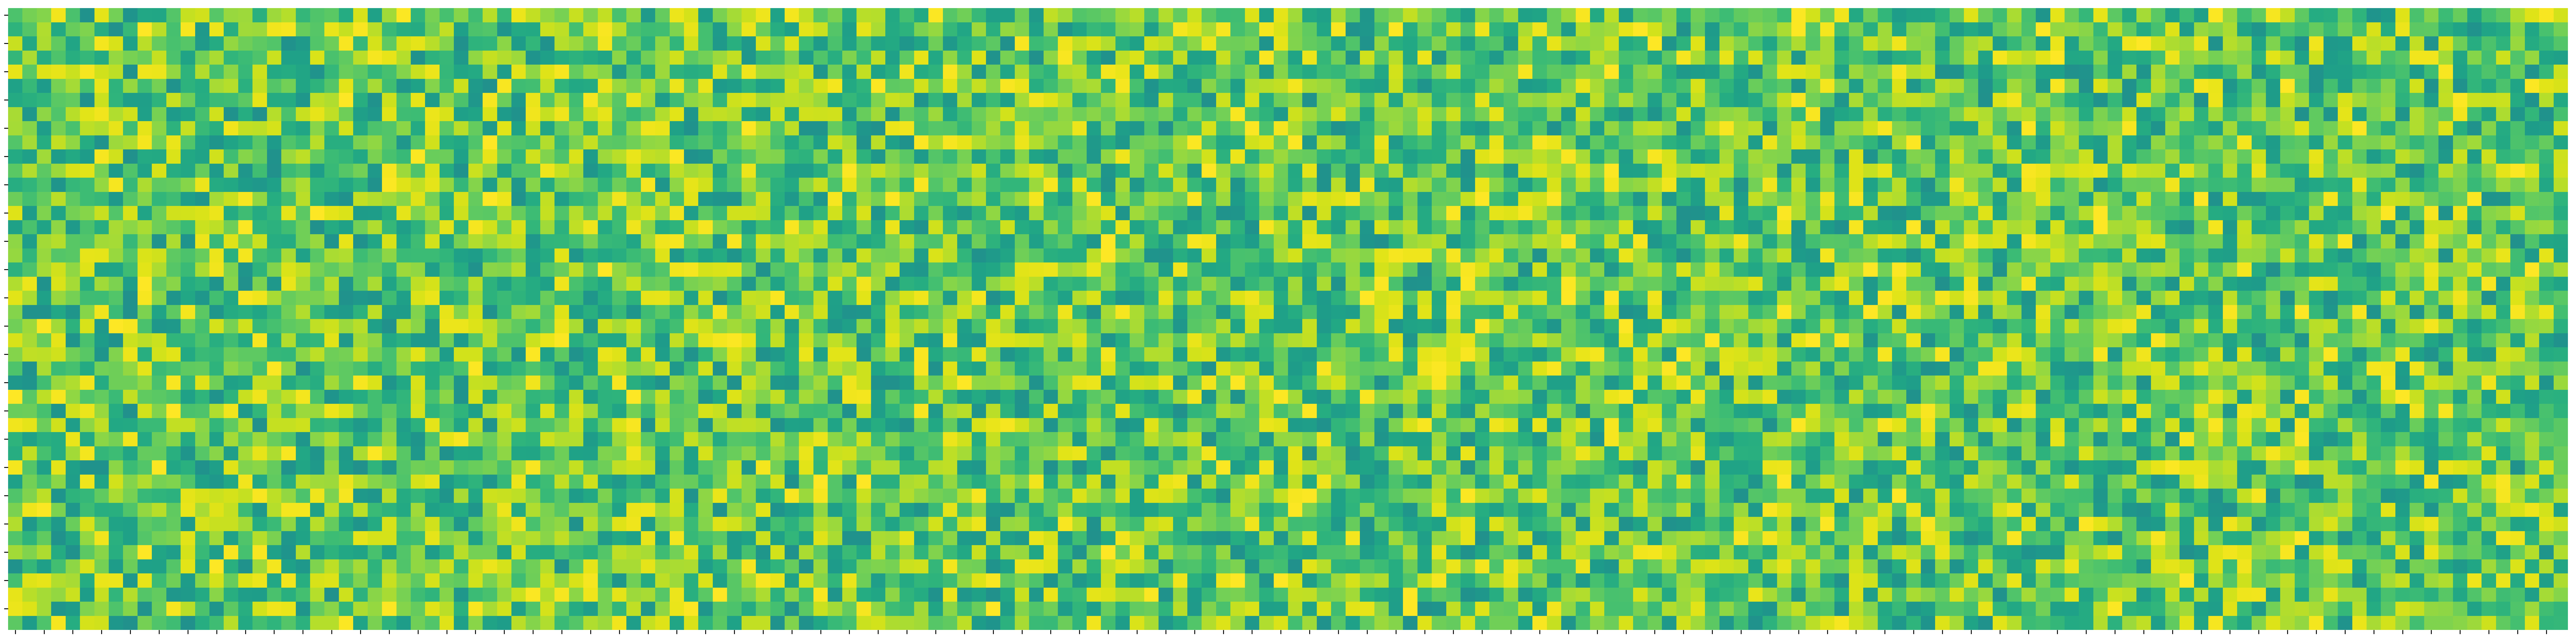

In [31]:
draw_heat_map(np.random.rand(44, 178), figure_size=(32,8), colors='viridis', useSVG=False, save_name='Figure/Full_Space_Heatmap', annot=False, show_label=None)

# Ligand分类

In [78]:
Ligand_1 = [1,3,4,5,6,9,10,11,12,14,15,16,17,19,20,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40] + [151,152,153,154,155,]
Ligand_2 = []

634.0

In [ ]:
[,41,44,45,46,48,49,50,51,52,54,56,57,58,59,61,62,63,64,65,66,67,68,69,70,
71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,91,92,93,94,95,96,97,98,99,100,
101,102,104,105,106,107,108,109,110,111,113,114,117,118,122,125,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,
,156,157,158,159,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205]

# 推荐配体的效果 & Box配体的效果

In [36]:
def calc_distribution_line(ys, eachsize=0.1, title=None, xlab=None, ylab="Freq", return_result = False, labels = None, colors = None, useSVG=False, save_name='test', figure_size=(5,4), xlimit = []):
    from scipy.interpolate import make_interp_spline
    fig = plt.figure(figsize=figure_size)
    y_max = np.max([max(each) for each in ys])
    y_min = np.min([min(each) for each in ys])
    # y_max = 50
    # y_min = 0
    if labels == None:
        labels = [None] * len(ys)
    if colors == None:
        colors = ["blue"] * len(ys)
    X = np.arange(y_min, y_max + eachsize, eachsize)
    # all_max = []
    all_des = []
    for idx, y in enumerate(ys):
        des = [0 for each in X]
        
        z = (y - y_min)/eachsize
        for each in z:
            try:
                assert int(each) < len(X)
                des[int(each)] += 1
            except:
                continue
        des = np.array(des)
        des = des / len(y)
        all_des.append(des)
        x = np.linspace(y_min - eachsize, y_max + eachsize * 2, 1000)
        # model = make_interp_spline(X, des, k=2)
        # ys = model(x)
        # all_max.append(max(ys))
        # print(x[np.argmax(ys)])
        # plt.plot(x, ys, color=colors[idx])
        # plt.fill_between(x, ys, 0, where=(ys > 0), interpolate=True, color=colors[idx], alpha=0.3, label=labels[idx])
        plt.bar(X + idx * eachsize/len(ys)/1.3 - eachsize/len(ys)/2.6, des, width=eachsize/len(ys)/1.3, color=colors[idx], label=labels[idx])
    if xlimit != []:
        plt.xlim(xlimit[0], xlimit[1])
    else:
        plt.xlim(y_min - eachsize, y_max + eachsize)
    # plt.ylim(0, 1.1 * max(all_max))
    plt.xlabel(xlab, fontsize=30)
    plt.ylabel(ylab, fontsize=30)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    if labels[0] != None:
        plt.legend()
    if title != None:
        plt.title = title
    if useSVG:
        plt.savefig(f"{save_name}.svg", bbox_inches='tight', format='svg')
    else:
        plt.savefig(f"{save_name}.png", dpi=300, bbox_inches='tight')
    plt.show()  
    if return_result:
        return X, all_des

In [15]:
pred_y = pd.read_csv("Pred_Important_Binol_09_25_0014_.csv")['PredER'].to_numpy()
box_y = full_data_csv.loc[np.isin(full_data_csv['Ligand'], [1001,1003,1019,1020,1052,1066,1071,1181,1184])]['PredER'].to_numpy()
calc_distribution_line([np.abs(pred_y), np.abs(box_y)], 3, ylab='', colors = ['#489b9c', '#719fff'], labels=['Recommended', "Universal"])

NameError: name 'full_data_csv' is not defined

In [52]:
box_y

array([], dtype=float64)

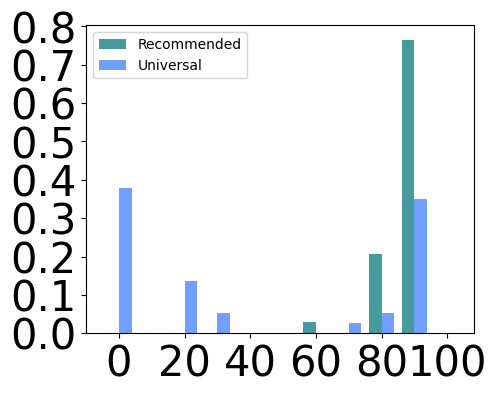

In [37]:
csv = pd.read_csv("Article_binol_ligand_exp_1008.csv").dropna()

new_y = np.abs(csv['R'] - csv['S'])
# box_y = csv.loc[np.isin(csv['Ligand14'], [1019])]['ER'].to_numpy()
# new_y = csv.loc[~np.isin(csv['Ligand14'], [1019])]['ER'].to_numpy()
# box_y = box_y[new_y > 60]
# new_y = new_y[new_y > 60]
box_csv = pd.read_csv("BINOL_result_Fig4.csv")
box_y = np.abs(box_csv['R'] - box_csv['S'])
results = calc_distribution_line([new_y, box_y], 10, ylab='', colors = ['#489b9c', '#719fff'], labels=['Recommended', "Universal"], return_result=True)

In [40]:
pd.DataFrame([results[0], results[1][0], results[1][1]]).T.to_csv("Distribution.csv", index=False)

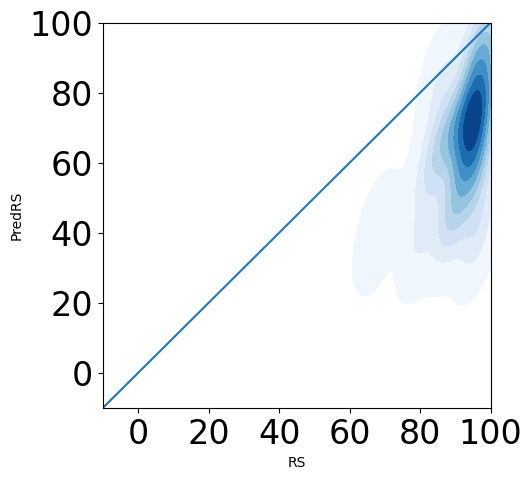

In [70]:
plot_scatter_with_metrics(np.abs(csv['RS']), np.abs(csv['PredRS']), min_=-10, max_=100)

In [ ]:
csv = pd.read_csv("Article_binol_ligand_exp_1008.csv").dropna()
csv['RS'] = np.abs(csv['R'] - csv['S'])
csv['PredRS'] = np.abs(csv['PredR'] - csv['PredS'])
# calc_distribution_line(csv['RS'], 3, ylab='', color = '#489b9c')
calc_distribution_line([np.abs(csv['RS']), np.abs(csv['PredRS'])], 10, ylab='', colors = ['#489b9c', '#719fff'], labels=['Real', "Pred"])

In [27]:
reactant_csv = pd.read_csv("Data_clear_with_sites.csv")
binol_all = binol_3_3 + binol_4_4 + binol_6_6 + binol_7_7 + binol_other
binol_csv = reactant_csv.loc[np.isin(reactant_csv['Index'], binol_all)]


In [28]:
allowed_ligand = [1,3,4,5,6,9,10,11,12,14,15,16,17,19,20,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,44,45,46,48,49,50,51,52,54,56,57,58,59,61,62,63,64,65,66,67,68,69,70,
71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,91,92,93,94,95,96,97,98,99,100,
101,102,104,105,106,107,108,109,110,111,113,114,117,118,122,125,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,
151,152,153,154,155,156,157,158,159,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205]

In [29]:
ligand_csv = reactant_csv.loc[(reactant_csv['Type']!= "Binol") & (np.isin(reactant_csv['Type_Index'], allowed_ligand))]

In [30]:
len(binol_csv), len(ligand_csv)

(44, 178)

In [36]:
[len(each) for each in all_binol_split]

[24, 3, 8, 5, 4]

In [45]:
len(ligand_csv.loc[ligand_csv['Type'] == 'Ligand_Box']), len(ligand_csv.loc[ligand_csv['Type'] == 'Ligand_Other'])

(139, 39)

In [198]:

pattens = ['C1(CC2=NCCO2)=NCCO1', 'C1(C2=NCCO2)=NC(C3=NCCO3)=CC=C1', "C1(C2=NCCO2)=N[C@H2]CO1", "C1(C2=NCCO2)=CC=CC=N1", "C1(C2=NCCN2)=NCCN1"]
isother = True
all_ligand_split = [[] for each in range(len(pattens) + 2)]
all_ligand_id = [[] for each in range(len(pattens) + 2)]
for row_id, row in ligand_csv.iterrows():
    for pattens_id, patten in enumerate(pattens):
        if Chem.MolFromSmiles(row['Smiles']).HasSubstructMatch(Chem.MolFromSmiles(patten)):
            isother = False
            all_ligand_split[pattens_id].append(row['Smiles'])
            all_ligand_id[pattens_id].append(row['Type_Index'])
            break
    if isother:
        if row['Type'] == 'Ligand_Box':
            all_ligand_split[-2].append(row['Smiles'])
            all_ligand_id[-2].append(row['Type_Index'])
        else:
            all_ligand_split[-1].append(row['Smiles'])
            all_ligand_id[-1].append(row['Type_Index'])
    isother = True
[len(each) for each in all_ligand_split]

[61, 7, 8, 31, 7, 25, 39]

In [77]:
binol_csv['Index'].to_numpy()

array([  0,   1,   2,   3,  13,  18,  19,  20,  21,  23,  24,  25,  26,
        28,  29,  30,  31,  32,  35,  36,  44,  45,  46,  47,  51,  52,
        56,  57,  60,  62,  63,  66,  85,  91, 121, 122, 123, 124, 125,
       126, 127, 128, 129, 130], dtype=int64)

In [84]:
from rdkit.Chem import rdAbbreviations
abbrevs = rdAbbreviations.GetDefaultAbbreviations()
custom_abbrevs = rdAbbreviations.ParseAbbreviations('''Ph c1ccccc1
''')

# 合并默认和自定义
for abbrev in abbrevs:
    custom_abbrevs.append(abbrev)
abbrevs = custom_abbrevs

In [177]:
from rdkit.Chem.Draw import rdMolDraw2D
opts = rdMolDraw2D.MolDrawOptions()
opts.baseFontSize = 0.8  # 元素字母基础大小（相对值，默认 0.6）
# opts.minFontSize = 12   # 最小字体大小（像素，默认 6）
# opts.maxFontSize = 30   # 最大字体大小（像素，默认 40）
# opts.fixedFontSize = -1 # 固定字体大小（-1 为不固定，默认 -1）
# opts.bondLineWidth = 3  # 键的宽度（像素，默认自动）
# opts.fixedBondLength = 30  # 键的长度（像素，>0 固定，默认 -1 为自动）
# opts.multipleBondOffset = 0.2  # 双键/多键间距（键长比例，默认 0.15）
# opts.legendFontSize = 16  # legends 字体大小（像素，默认自动）
# opts.legendFraction = 0.2  # legends 占用绘图面板比例（默认 0.15）

In [91]:
opts

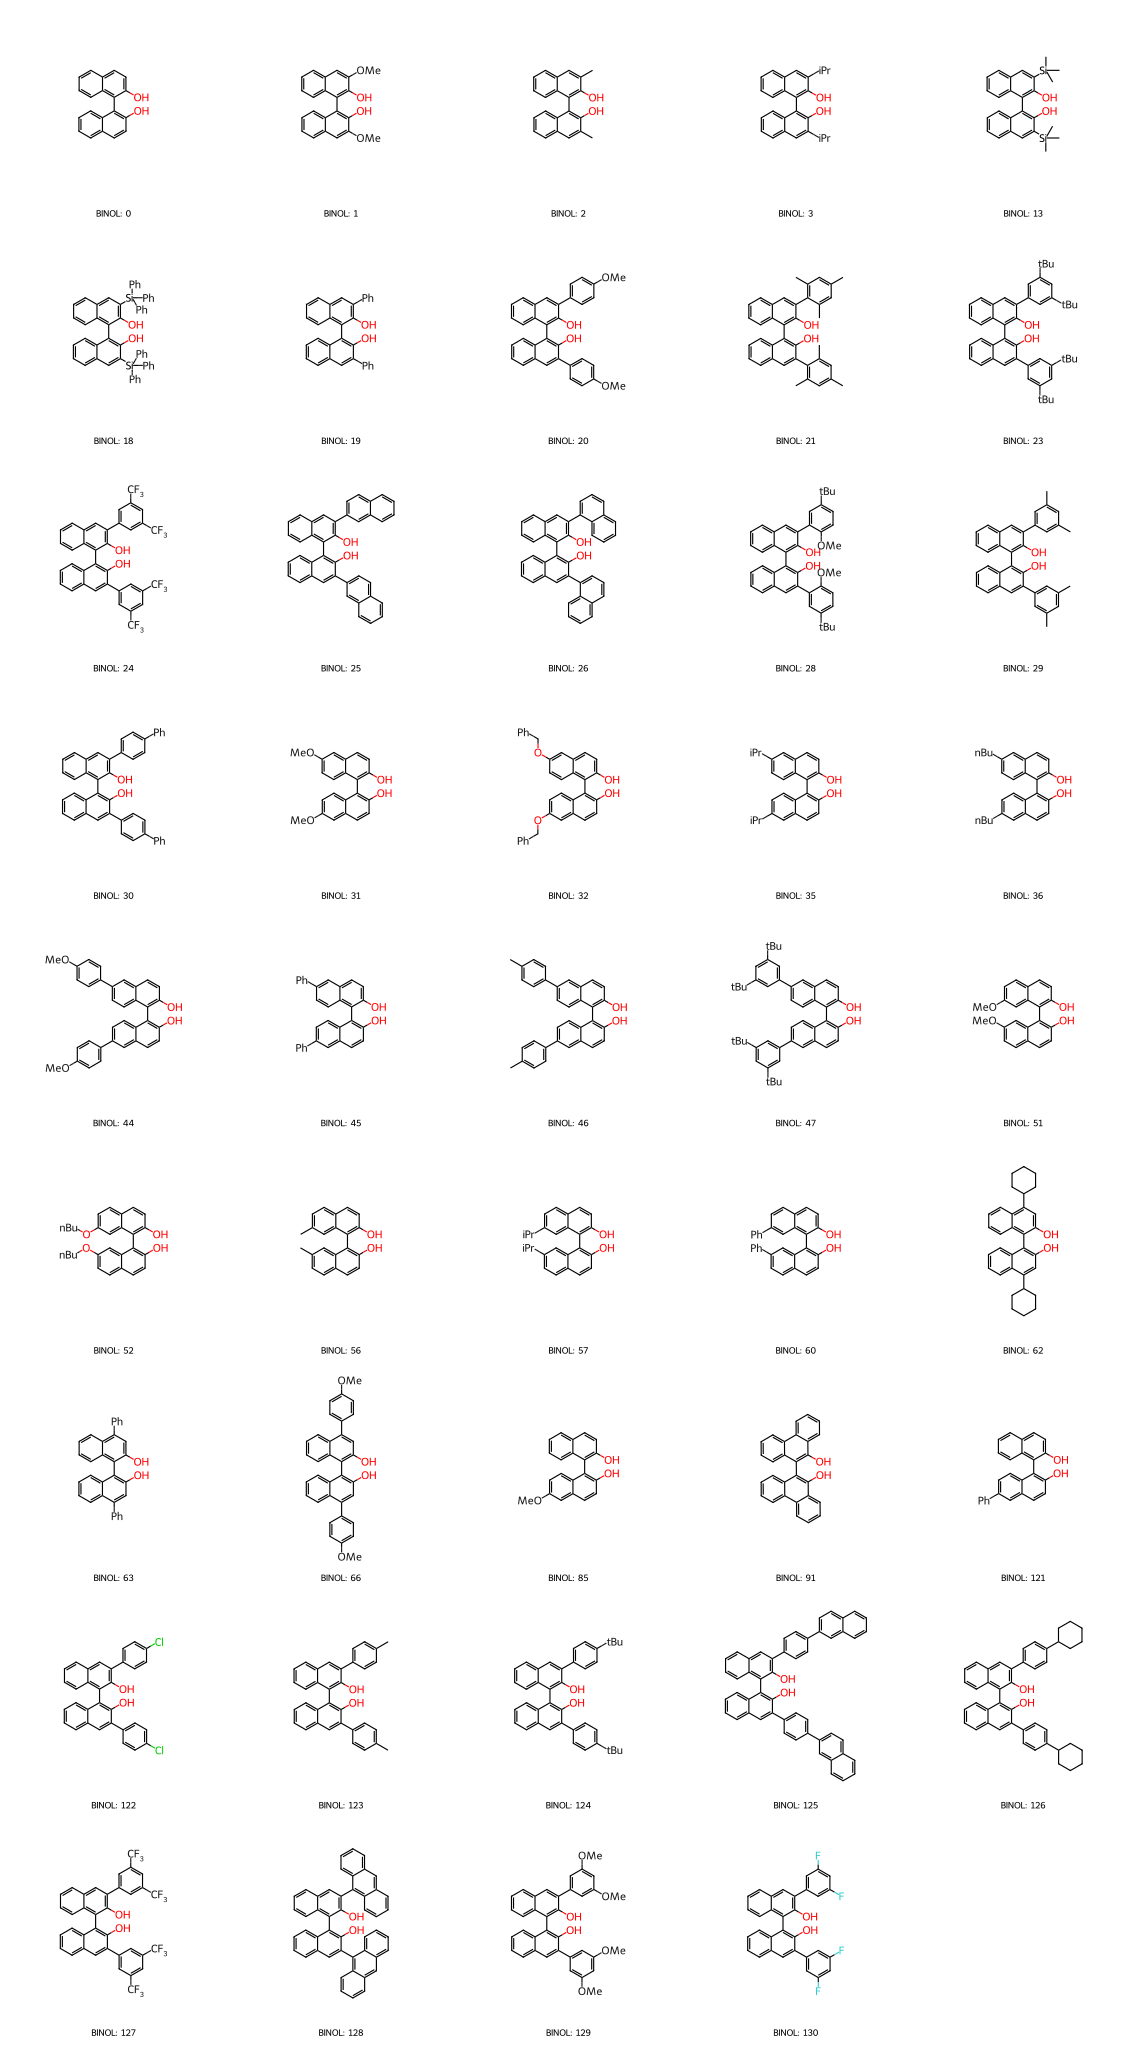

In [205]:
from rdkit.Chem import AllChem, rdFMCS
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)
start_id = 0
end_id = start_id + 50
csv_ = binol_csv

mols = [rdAbbreviations.CondenseMolAbbreviations(Chem.MolFromSmiles(each), abbrevs, maxCoverage=1) for each in csv_['Smiles']][start_id:end_id]
# template = Chem.MolFromSmarts("Oc1ccccc1-c1ccccc1O")
# AllChem.Compute2DCoords(template)
template = Chem.MolFromMolFile(f"Figure/BINOL_patten0.mol")

aligned_queries = []
for mol in mols:
    AllChem.Compute2DCoords(mol)  # 先计算初始坐标
    AllChem.GenerateDepictionMatching2DStructure(mol, template)  # 匹配模板
    aligned_queries.append(mol)
mols = aligned_queries
Chem.Draw.MolsToGridImage(mols, 
                          molsPerRow=5, subImgSize=(400, 400), useSVG=True, 
                          legends = ["BINOL: " + str(each) for each in csv_['Type_Index']][start_id:end_id], 
                          drawOptions=opts)

not symmetry： 85 121

In [201]:
start_id = 0
split_id = 0
end_id = start_id + 50
csv_ = ligand_csv
template = Chem.MolFromSmiles('Oc1ccccc1-c1ccccc1O')
AllChem.Compute2DCoords(template)
Chem.MolToMolFile(template, f"Figure/BINOL_patten{split_id}.mol")

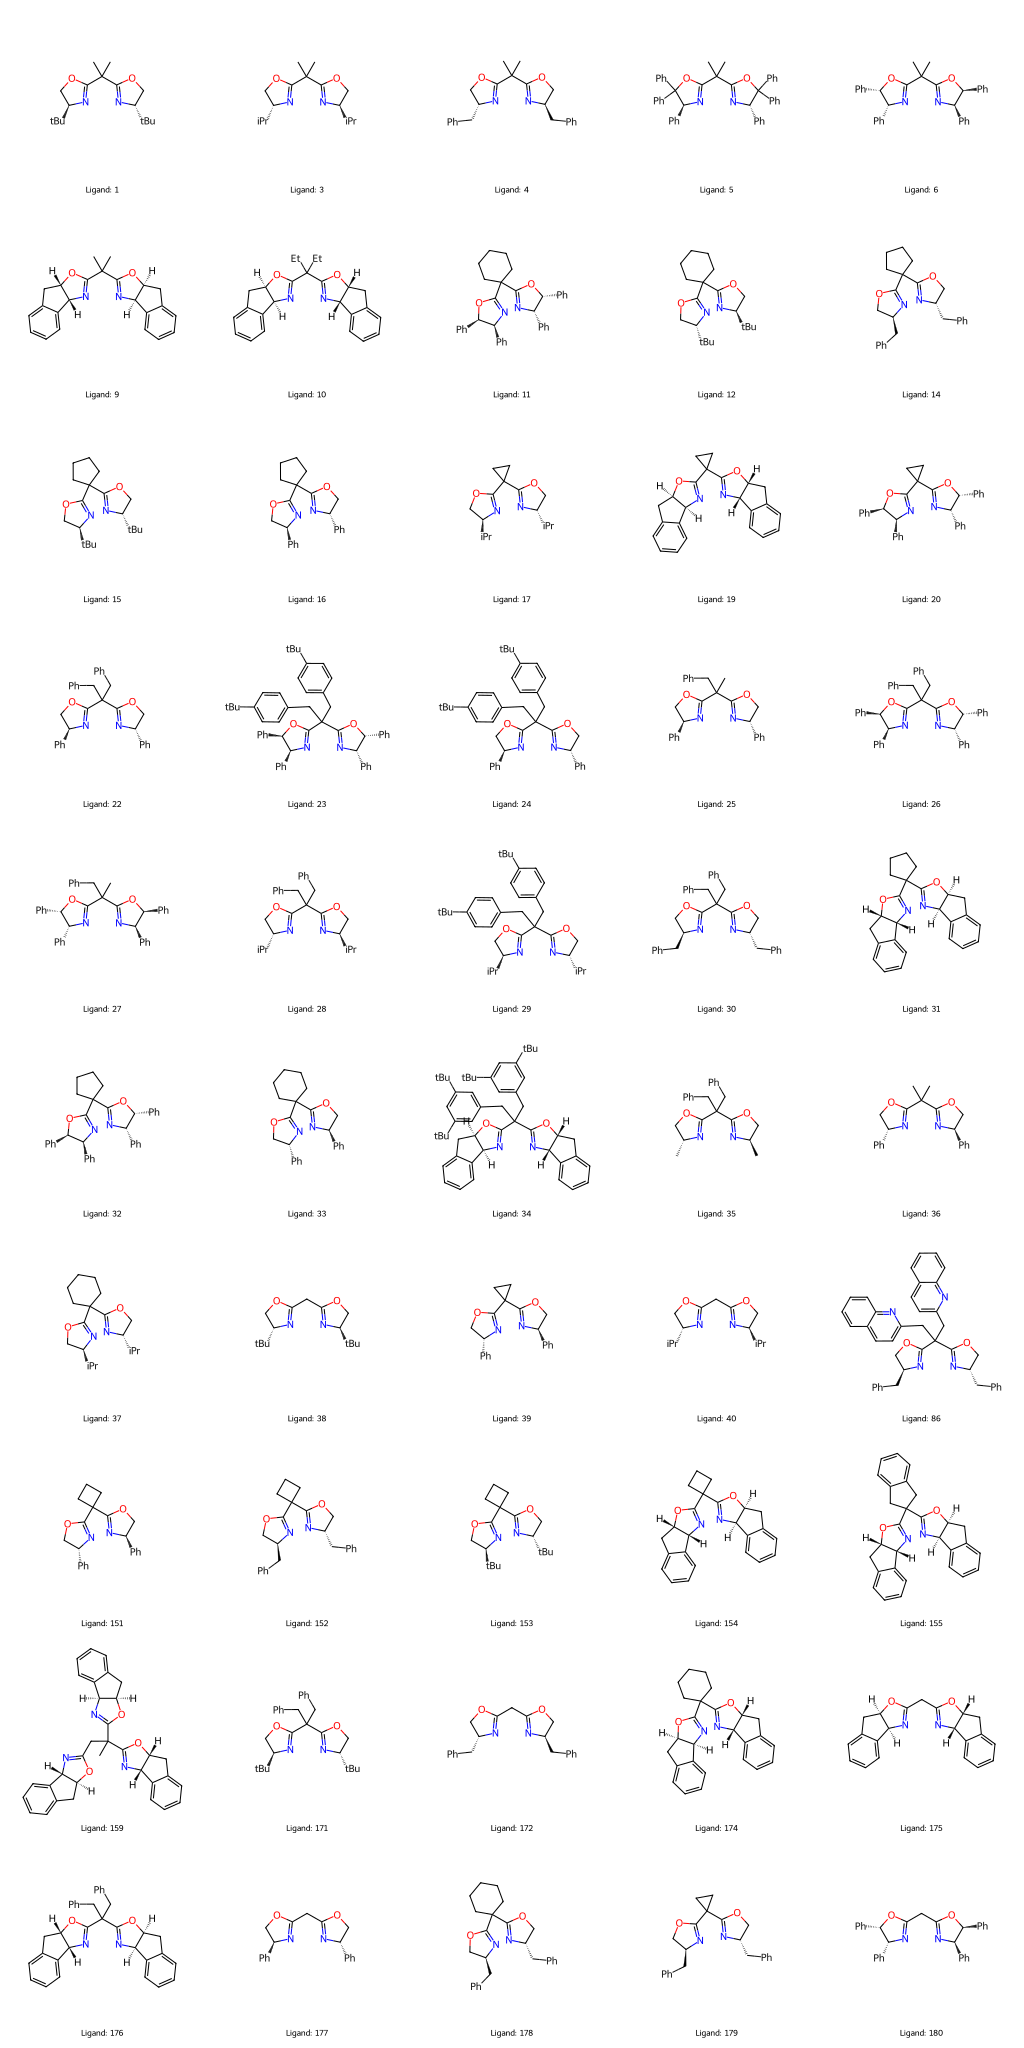

In [217]:
from rdkit.Chem import AllChem, rdFMCS
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)
start_id = 0
split_id = 0
end_id = start_id + 50
csv_ = ligand_csv

mols = [rdAbbreviations.CondenseMolAbbreviations(Chem.MolFromSmiles(each), abbrevs, maxCoverage=1) for each in all_ligand_split[split_id]][start_id:end_id]
# template = Chem.MolFromSmiles(pattens[split_id])
template = Chem.MolFromMolFile(f"Figure/ligand_patten{split_id}.mol")
# AllChem.Compute2DCoords(template)
aligned_queries = []
for mol in mols:
    AllChem.Compute2DCoords(mol)
    # mcs = rdFMCS.FindMCS([template, mol])
    # patt = Chem.MolFromSmarts(mcs.smartsString)
    # query_match = mol.GetSubstructMatch(patt)
    # template_match = template.GetSubstructMatch(patt)
    # AllChem.AlignMol(mol, template, atomMap=list(zip(query_match, template_match)))
    AllChem.GenerateDepictionMatching2DStructure(mol, template)  # 匹配模板
    aligned_queries.append(mol)
mols = aligned_queries
Chem.Draw.MolsToGridImage(mols, 
                          molsPerRow=5, subImgSize=(400, 400), useSVG=True, 
                          legends = ["Ligand: " + str(each) for each in all_ligand_id[split_id]][start_id:end_id], 
                          drawOptions=opts)

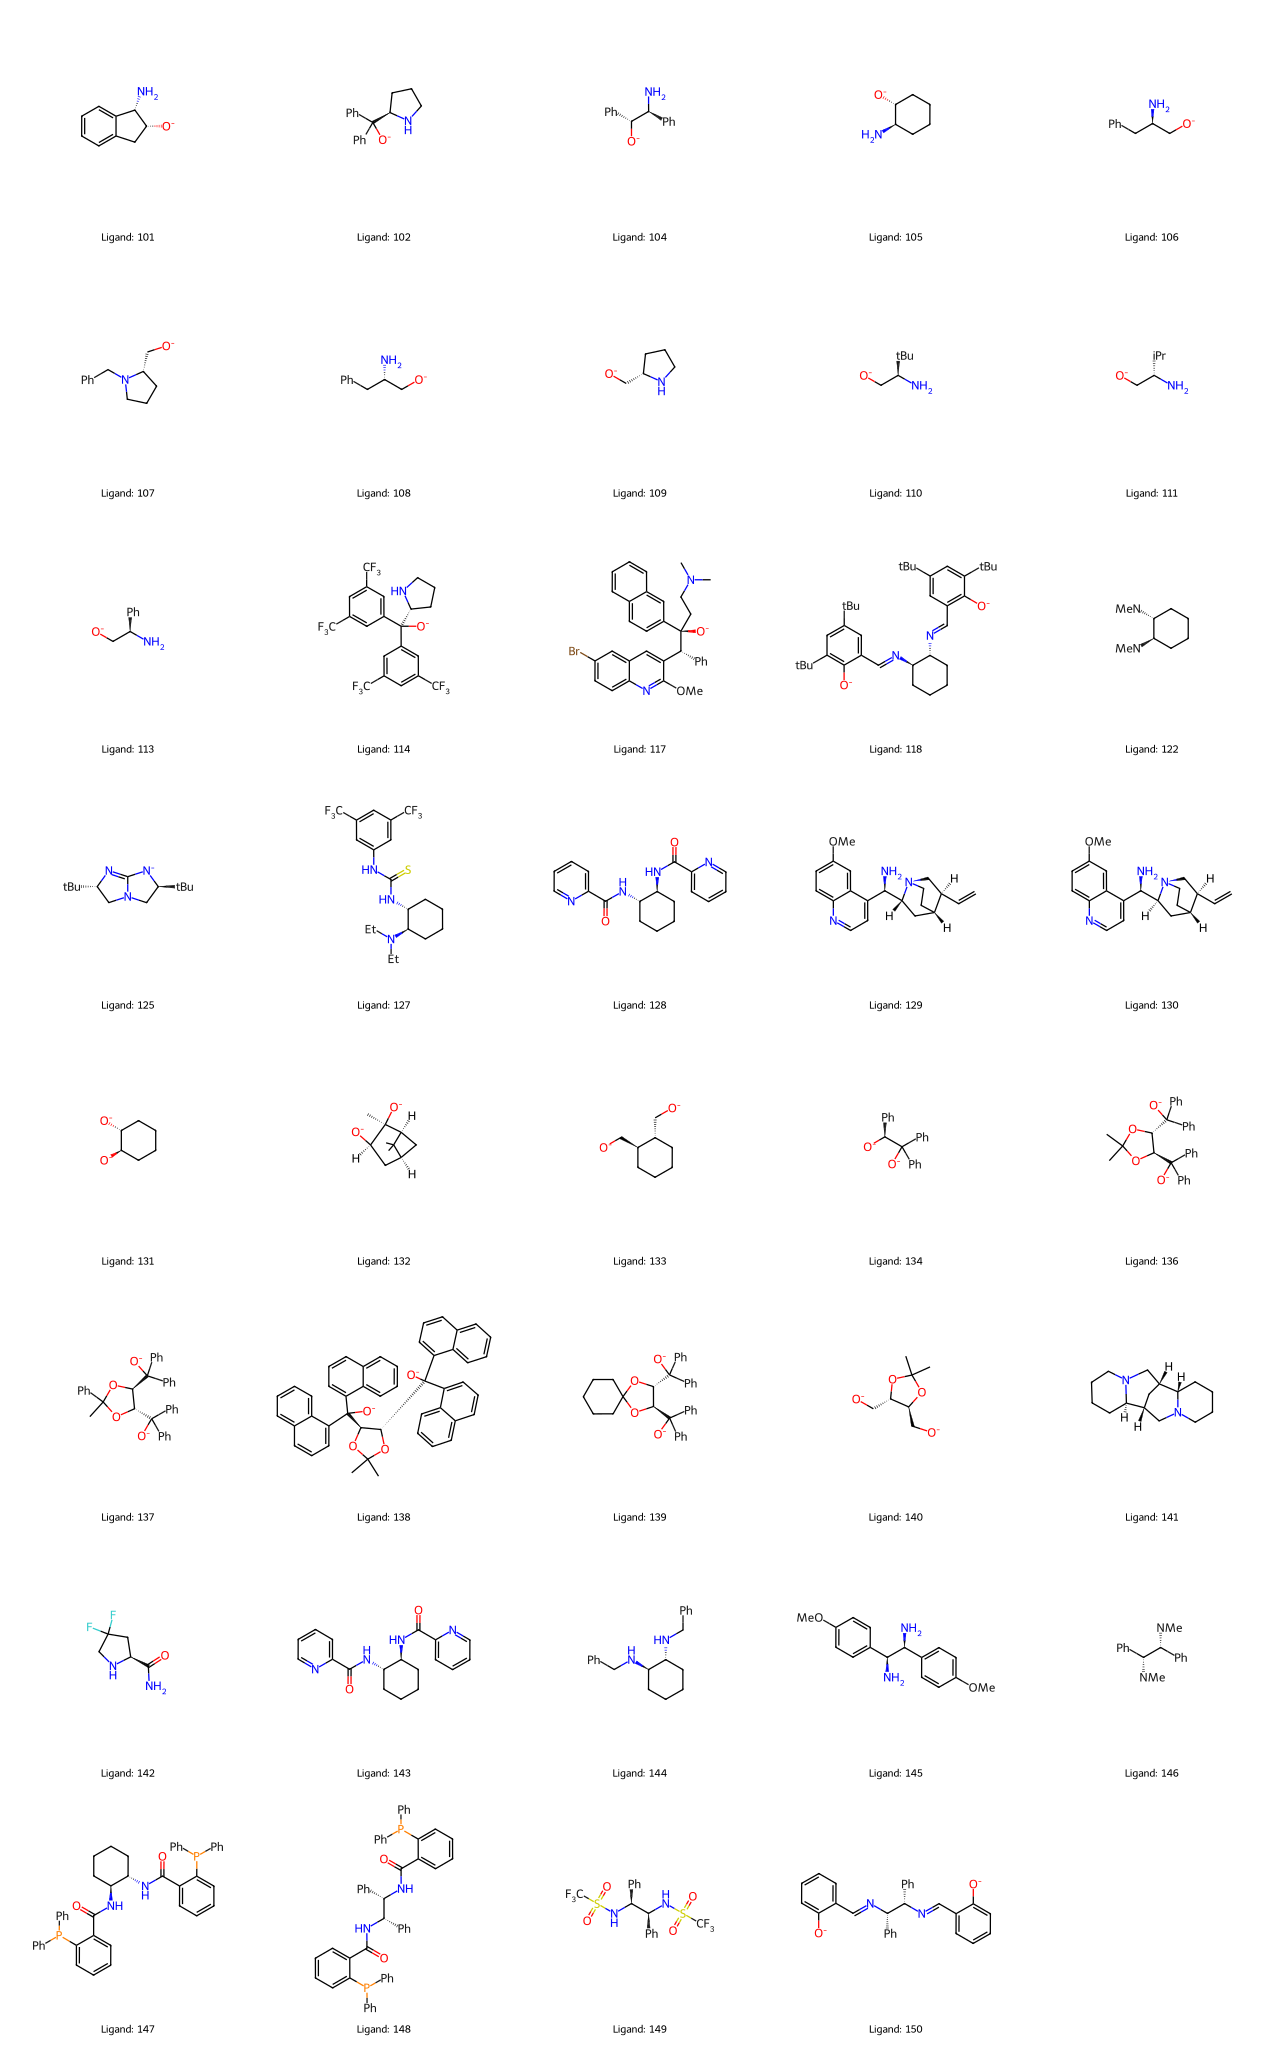

In [215]:
from rdkit.Chem import AllChem, rdFMCS
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)
start_id = 0
split_id = 6
end_id = start_id + 50
csv_ = ligand_csv

mols = [rdAbbreviations.CondenseMolAbbreviations(Chem.MolFromSmiles(each), abbrevs, maxCoverage=1) for each in all_ligand_split[split_id]][start_id:end_id]

# from rdkit.Chem.Draw import rdMolDraw2D
opts = rdMolDraw2D.MolDrawOptions()
opts.baseFontSize = 0.6  # 元素字母基础大小（相对值，默认 0.6）
# opts.padding = 0.15

Chem.Draw.MolsToGridImage(mols, 
                          molsPerRow=5, subImgSize=(400, 400), useSVG=True, 
                          legends = ["Ligand: " + str(each) for each in all_ligand_id[split_id]][start_id:end_id], 
                          drawOptions=opts)

In [161]:
template_match

(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10)

In [1]:
from openbabel import pybel

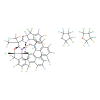

In [3]:
mol = next(pybel.readfile("cif", r'ignored\t.cif'))
mol

In [8]:
from rdkit import Chem
molblock=mol.write("mol")    #write out as a molfile string and ship that now into rdkit

mol = Chem.MolFromMolBlock(molblock,removeHs=False)
Chem.MolToMolFile(mol, "ignored\R.mol")